# The Race and Salary of Developers who use Stack Overflow - An analysis of the fairness of the Stack Overflow 2018 Survey data using IBM’s AI Fairness 360 Toolkit

# By Ria Cheruvu

8/7/2019

The purpose of this blog post is to apply IBM's AI Fairness 360 Toolkit for the Stack Overflow 2018 Survey dataset. The following content will be covered:

- Definitions of commonly used fairness metrics.
- The application of a pre-processing algorithm to ensure fairness before classification.
- Steps and results for training and evaluating machine learning algorithms on the original and pre-processed data. We evaluate the effects of fairness on the predictive accuracy of the models in addition to feature importances.

For information on how to setup your conda environment to run the code, please see environment_setup_steps.txt and environment.yml that come along with this .ipynb file/gist.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#The-AI-Fairness-360-Toolkit" data-toc-modified-id="The-AI-Fairness-360-Toolkit-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>The AI Fairness 360 Toolkit</a></span><ul class="toc-item"><li><span><a href="#Important-Definitions-associated-with-the-toolkit" data-toc-modified-id="Important-Definitions-associated-with-the-toolkit-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Important Definitions associated with the toolkit</a></span></li><li><span><a href="#Narrowing-the-scope-of-the-blog-post" data-toc-modified-id="Narrowing-the-scope-of-the-blog-post-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Narrowing the scope of the blog post</a></span></li></ul></li><li><span><a href="#Stack-Overflow's-2018-developer-survey" data-toc-modified-id="Stack-Overflow's-2018-developer-survey-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Stack Overflow's 2018 developer survey</a></span></li></ul></li><li><span><a href="#Importing-necessary-packages" data-toc-modified-id="Importing-necessary-packages-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing necessary packages</a></span></li><li><span><a href="#Reading-in-and-pre-processing-data" data-toc-modified-id="Reading-in-and-pre-processing-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reading in and pre-processing data</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualization</a></span></li><li><span><a href="#One-hot-encoding-and-data-splitting" data-toc-modified-id="One-hot-encoding-and-data-splitting-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>One-hot-encoding and data splitting</a></span></li><li><span><a href="#Analyzing-metrics-on-original-data" data-toc-modified-id="Analyzing-metrics-on-original-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Analyzing metrics on original data</a></span></li><li><span><a href="#Pre-Processing-algorithms:-Reweighing" data-toc-modified-id="Pre-Processing-algorithms:-Reweighing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Pre-Processing algorithms: Reweighing</a></span></li><li><span><a href="#Train/test-ML-algorithms-on-original-and-transformed-data-to-evaluate-effects-of-fairness-on-predictive-accuracy" data-toc-modified-id="Train/test-ML-algorithms-on-original-and-transformed-data-to-evaluate-effects-of-fairness-on-predictive-accuracy-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Train/test ML algorithms on original and transformed data to evaluate effects of fairness on predictive accuracy</a></span><ul class="toc-item"><li><span><a href="#Training-on-original-data" data-toc-modified-id="Training-on-original-data-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Training on original data</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-8.1.2"><span class="toc-item-num">8.1.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Comparisons-between-the-models" data-toc-modified-id="Comparisons-between-the-models-8.1.3"><span class="toc-item-num">8.1.3&nbsp;&nbsp;</span>Comparisons between the models</a></span></li></ul></li><li><span><a href="#Results-on-the-reweighed-dataset" data-toc-modified-id="Results-on-the-reweighed-dataset-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Results on the reweighed dataset</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>Random Forests</a></span></li><li><span><a href="#Comparisons-between-the-models" data-toc-modified-id="Comparisons-between-the-models-8.2.3"><span class="toc-item-num">8.2.3&nbsp;&nbsp;</span>Comparisons between the models</a></span></li></ul></li></ul></li><li><span><a href="#Key-takeaways-and-future-directions" data-toc-modified-id="Key-takeaways-and-future-directions-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Key-takeaways and future directions</a></span></li><li><span><a href="#Credits" data-toc-modified-id="Credits-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Credits</a></span></li></ul></div>

-------------------------------------------------------------------------------------------------------------------------------

## Introduction 

### The AI Fairness 360 Toolkit

The AI Fairness 360 Toolkit (AIF360 Toolkit) is an open-source toolkit created by IBM researchers that can identify and help remove bias in the machine learning pipeline (data -> classifier -> predictions). 

In terms of identifying bias, the toolkit outputs metrics such as statistical parity difference, equal opportunity difference, disparate impact, the Theil index, etc. to help researchers analyze the effects of bias on the data. Researchers can apply algorithms provided by the toolkit at different stages of the machine learning pipeline to reduce the effects of the bias on the data. You can visit https://aif360.mybluemix.net/ to learn more about the toolkit.

Pre-processing algorithms can be applied for the training data, in-processing algorithms for the meachine learning classifiers, and post-processing algorithms can be applied for the test data.

In order to validate the transformation of the data performed by the toolkit's algorithms, researchers can then train classifiers to evaluate the accuracy of the model on the original and transformed datasets.

For the purpose of this tutorial, we will focus on using a pre-processing algorithm called reweighing, which will be described in detail later on.

Below is a table containing the experimental setups supported by the AIF360 Toolkit.

![alt Algorithms supported by AIF360 Toolkit](https://gist.githubusercontent.com/riacheruvu/6af470459018959db6e6a69d1e5294ee/raw/bf7e8d46bfa14f09c0c7b438e7894b6950c5d30d/IBM_AIF360.PNG)

#### Important Definitions associated with the toolkit

These definitions are taken from the "AI Fairness 360: An Extensible Toolkit for Detecting, Understanding, and Mitigating Unwated Algorithmic Bias" (https://arxiv.org/pdf/1810.01943.pdf) paper and modified:

- Favorable label: "A favorable label is a label whose value corresponds to an outcome that provides an advantage to the recipient. Examples are receiving a loan, being hired for a job, and not being arrested."

- Protected attribute: "A protected attribute is an attribute that partitions a population into groups that have parity in terms of benefit received. Examples include race, gender, caste, and religion."

- Privileged group: A privileged value of a protected attribute indicates a group that has historically been at a systematic advantage.

<div class="alert alert-info">
<b>Fairness metrics explanation:</b> 
    
<p>I include this note with relevant definitions when fairness metrics are printed in the notebook</p>

<br />

    
**Balanced accuracy** - Balanced accuracy is used to "avoid inflated performance estimates on imbalanced datasets... In the binary case, balanced accuracy is equal to the arithmetic mean of sensitivity (true positive rate) and specificity (true negative rate), or the area under the ROC curve with binary predictions rather than scores." - Taken from Scikit-Learn's documentation on model evaluation (https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score).

<br />

**Average odds difference** - This is the average of difference in false positive rates and true positive rates between unprivileged and privileged groups. A value of 0 implies both groups have equal beneﬁt, a value less than 0 implies higher beneﬁt for the privileged group and a value greater than 0 implies higher beneﬁt for the unprivileged group.

<br />


**Equal opportunity difference** - This is the difference in true positive rates between unprivileged and privileged groups. A value of 0 implies both groups have equal beneﬁt, a value less than 0 implies higher beneﬁt for the privileged group and a value greater than 0 implies higher beneﬁt for the unprivileged group.

<br />


**Statistical Parity Difference** - This is the difference in the probability of favorable outcomes between the unprivileged and privileged groups. A value of 0 implies both groups have equal beneﬁt, a value less than 0 implies higher beneﬁt for the privileged group, and a value greater than 0 implies higher beneﬁt for the unprivileged group.

<br />


**Disparate Impact** - This is the ratio in the probability of favorable outcomes between the unprivileged and privileged groups. A value of 1 implies both groups have equal beneﬁt, a value less than 1 implies higher beneﬁt for the privileged group, and a value greater than 1 implies higher beneﬁt for the unprivileged group. In the AIF360 toolkit tutorials, 1 - min(disparate impact, 1/disparate impact) or 1-min(DI, 1/DI) is used and the goal is to make sure this metric is less than 0.2, since in the authors' words, "it's possible to overcorrect and end up with a value greater than 1, implying unfairness for the original privileged group" - taken from https://github.com/IBM/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb.

<br />


**Theil index**: - "The Theil index is a statistic primarily used to measure economic inequality and other economic phenomena, though it has also been used to measure racial segregation. The Theil index TT is the same as redundancy in information theory which is the maximum possible entropy of the data minus the observed entropy." Taken from https://en.wikipedia.org/wiki/Theil_index

<br />


**Consistency**: An individual fairness metric that "assesses the consistency of the model’s classification prediction of a given data item x to its k-nearest neighbors; values close to one indicate that similar inputs are treated similarly." - Taken from "Learning Fair Representations" (https://www.cs.toronto.edu/~toni/Papers/icml-final.pdf).

Citation: The above information is taken from the "AI Fairness 360: An Extensible Toolkit for Detecting, Understanding, and Mitigating Unwated Algorithmic Bias" (https://arxiv.org/pdf/1810.01943.pdf) paper and modified.


</div>


<div class="alert alert-warning">
<b>Code Consideration:</b> 

Results for the fairness metrics, accuracy, the F1 score, etc. may vary from run to run.
</div>

#### Narrowing the scope of the blog post

For the purposes of this project, only select features of the toolkit will be utilized, which will impose limitations on the problem formalization. These limitations include:

- The problem must be a binary classification problem - there will be only one, binary output label.

- Only one protected attribute will be utilized.

- The re-weighing algorithm will be the bias-mitigation algorithm covered.

- The goal of this project is not to find the optimal machine learning model.

### Stack Overflow's 2018 developer survey

Stack Overflow's developer survey, offered in 2018, offers a rich amount of data from more than 67,000 developers about their background, interests, career, etc. This data is available on Kaggle at this link: https://www.kaggle.com/stackoverflow/stack-overflow-2018-developer-survey

Some of the Kaggle kernels associated with this dataset reveal that the data is highly unrepresentative of race, gender, and other factors (a form of non-reponse bias), which is an important quality of the dataset we will touch upon later.

For the purposes of this project, the problem formalization is as follows:

We would like to predict the Salary of the survey participants (in US dollars) given information such as whether or not they are a student, what type of formal education do they have, how many years of coding experience do they have, how satisfied they are with their career, and their race/ethnicity.

Race/Ethnicity will serve as the protected attribute of my dataset - a protected attribute enables the partitioning of a population into groups that have parity in terms of benefit received (in this case, the benefit is a salary higher than 60K).  As part of this problem formalization, I define Caucasian individuals as a privileged group (a group that has historically been at a systematic advantage) and non-Caucasian individuals as a non-privileged group. Given this formalization, the toolkit can then output fairness metrics, such as statistical parity difference, the Theil index, and equal opportunity difference value for the dataset.

## Importing necessary packages

In [1]:
# Load necessary packages
import sys
sys.path.insert(1, "../")  
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer 
from tqdm import tqdm
from aif360.datasets import StandardDataset, StructuredDataset, BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.metrics import accuracy_score
from IPython.display import Markdown, display
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from typing import List, Union, Dict
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score, auc
from collections import defaultdict

## Reading in and pre-processing data

Having downloaded the .csv file to our local directory, let's start the analysis.

We see there are 98,855 rows and 129 columns.

In [2]:
survey_data = pd.read_csv("aif360\data\survey_results_public.csv")
survey_data.shape

c:\users\turia\anaconda3\envs\aif360\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(98855, 129)

Let's view the first few rows of the dataset:

In [3]:
survey_data.head()

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


Out of 129 columns, we can pick which variables are most relevant for solving our particular problem statement - most columns are not useful for the purpose of our analysis, due to:

- Irrelevancy: For example, when the survey participant wakes up.
- SO-specific questions: For example, when the user created a SO account.
- Tech-specific questions: For example, what operating system does the user prefer.

The names of the columns are included below:

In [4]:
col_names = list(survey_data.columns)
col_names

['Respondent',
 'Hobby',
 'OpenSource',
 'Country',
 'Student',
 'Employment',
 'FormalEducation',
 'UndergradMajor',
 'CompanySize',
 'DevType',
 'YearsCoding',
 'YearsCodingProf',
 'JobSatisfaction',
 'CareerSatisfaction',
 'HopeFiveYears',
 'JobSearchStatus',
 'LastNewJob',
 'AssessJob1',
 'AssessJob2',
 'AssessJob3',
 'AssessJob4',
 'AssessJob5',
 'AssessJob6',
 'AssessJob7',
 'AssessJob8',
 'AssessJob9',
 'AssessJob10',
 'AssessBenefits1',
 'AssessBenefits2',
 'AssessBenefits3',
 'AssessBenefits4',
 'AssessBenefits5',
 'AssessBenefits6',
 'AssessBenefits7',
 'AssessBenefits8',
 'AssessBenefits9',
 'AssessBenefits10',
 'AssessBenefits11',
 'JobContactPriorities1',
 'JobContactPriorities2',
 'JobContactPriorities3',
 'JobContactPriorities4',
 'JobContactPriorities5',
 'JobEmailPriorities1',
 'JobEmailPriorities2',
 'JobEmailPriorities3',
 'JobEmailPriorities4',
 'JobEmailPriorities5',
 'JobEmailPriorities6',
 'JobEmailPriorities7',
 'UpdateCV',
 'Currency',
 'Salary',
 'SalaryType',

We can formalize the problem as the following:

- Variable to predict: ConvertedSalary (Numerical variable that needs to be converted to a Categorical variable)


Predictor variables:

- Student (Categorical)
- FormalEducation (Categorical)
- YearsCoding (Categorical)
- CareerSatisfaction (Categorical)
- DevType (Categorical)

Protected attribute (that is also a predictor variable):

- RaceEthnicity (Categorical)
    - Privileged value: White
    - Unprivileged value: Not white

Below, we trim the dataset based on the problem formalization, and drop na values.

In [5]:
new_results = survey_data[['Student','FormalEducation', 'YearsCoding', 'CareerSatisfaction', 'DevType', 'RaceEthnicity', 'ConvertedSalary']]
new_results = new_results.dropna()  #Here, we use the dropna() function to drop NA values
new_results.head()

,Student,FormalEducation,YearsCoding,CareerSatisfaction,DevType,RaceEthnicity,ConvertedSalary
1,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",30 or more years,Neither satisfied nor dissatisfied,Database administrator;DevOps specialist;Full-...,White or of European descent,70841.0
4,"Yes, part-time",Some college/university study without earning ...,6-8 years,Moderately satisfied,Data or business analyst;Desktop or enterprise...,White or of European descent,21426.0
5,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",6-8 years,Slightly satisfied,Back-end developer;Database administrator;Fron...,White or of European descent,41671.0
6,No,Some college/university study without earning ...,9-11 years,Moderately satisfied,Back-end developer;Front-end developer;Full-st...,White or of European descent,120000.0
8,No,Some college/university study without earning ...,30 or more years,Moderately satisfied,"Back-end developer;C-suite executive (CEO, CTO...",White or of European descent,250000.0


We now see that the number of rows is 39,647 and the number of columns is 7.

In [6]:
print(new_results.shape)

(39647, 7)


<div class="alert alert-warning">
<b>Dataset Consideration:</b> 

At this point, we need to inspect the *values* of the variables closely in order to determine if any further pre-processing steps are necessary. 

Below, we see that the values of the RaceEthnicity variable contains multiple values seperated by semicolons, due to the nature of the survey question being a "check all that apply" question. The question asked for RaceEthnicity is: "Which of the following do you identify as? Please check all that apply. If you prefer not to answer, you may leave this question blank."

Since this complicates the analysis, for this variable, I remove text following the semicolon to narrow down the values of the variables. The options to the left of the first semicolons differ between rows, suggesting that a participant's first choice is the value to the left of the first semicolons.
</div>

In [7]:
print(new_results['RaceEthnicity'].unique())

['White or of European descent'
 'Hispanic or Latino/Latina;White or of European descent' 'South Asian'
 'East Asian' 'Hispanic or Latino/Latina' 'Middle Eastern'
 'Black or of African descent'
 'Middle Eastern;White or of European descent'
 'East Asian;White or of European descent'
 'South Asian;White or of European descent' 'East Asian;South Asian'
 'Native American, Pacific Islander, or Indigenous Australian'
 'Black or of African descent;White or of European descent'
 'Native American, Pacific Islander, or Indigenous Australian;White or of European descent'
 'Black or of African descent;Hispanic or Latino/Latina'
 'Black or of African descent;Hispanic or Latino/Latina;White or of European descent'
 'East Asian;Hispanic or Latino/Latina'
 'Black or of African descent;Native American, Pacific Islander, or Indigenous Australian;White or of European descent'
 'Black or of African descent;East Asian;Hispanic or Latino/Latina;Middle Eastern;Native American, Pacific Islander, or Indigenou

In [8]:
new_results['RaceEthnicity'] = new_results['RaceEthnicity'].str.split(r';').str.get(0)
print(new_results['RaceEthnicity'].unique())

['White or of European descent' 'Hispanic or Latino/Latina' 'South Asian'
 'East Asian' 'Middle Eastern' 'Black or of African descent'
 'Native American, Pacific Islander, or Indigenous Australian']


We now see that the values of the RaceEthnicity variable have been narrowed down to White, South Asian, Hispanic, Native American, East Asian, Black, and Middle Eastern.

<div class="alert alert-warning">
<b>Project Consideration:</b> 

It would be relevant to include the type of the developer as part of this formalization, as salary depends on the developer role/position. However, as we see below, even after removing values after the semicolon, the number of unique values of the DevType variable is relatively large, so we perform similar pre-processing as done with the RaceEthinicity variable for the DevType variable.

</div>

In [9]:
len(new_results['DevType'].unique())
new_results['DevType'] = survey_data['DevType'].str.split(r';').str.get(0)
print(new_results['DevType'].unique())

['Database administrator' 'Data or business analyst' 'Back-end developer'
 'Full-stack developer' 'Front-end developer' 'Designer'
 'Embedded applications or devices developer' 'QA or test developer'
 'Engineering manager' 'DevOps specialist'
 'Data scientist or machine learning specialist' 'Mobile developer'
 'Desktop or enterprise applications developer'
 'C-suite executive (CEO, CTO, etc.)' 'System administrator'
 'Educator or academic researcher' 'Game or graphics developer'
 'Product manager' 'Student' 'Marketing or sales professional']


Next, we need to ensure that the variable we are trying to predict, ConvertedSalary, is categorical due to limitations of the features we are using provided by the toolkit.

For the purposes of this analysis, we can use the median of the variable as the cutting-off point. Below, we see the median of Converted Salary is approximately 60,000, which is what I use to bin the ConvertedSalary categorical variable (values less than 60,000 are categorized as 0 and values greater than 60,000 are categorized as 1).

In [10]:
new_results.describe(include='all')

,Student,FormalEducation,YearsCoding,CareerSatisfaction,DevType,RaceEthnicity,ConvertedSalary
count,39647,39647,39647,39647,39647,39647,3.964700e+04
unique,3,9,11,7,20,7,NaN
top,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",6-8 years,Moderately satisfied,Back-end developer,White or of European descent,NaN
freq,33227,19259,8493,15629,24525,29389,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.001826e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,2.054820e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,2.937600e+04
50%,NaN,NaN,NaN,NaN,NaN,NaN,5.919800e+04
75%,NaN,NaN,NaN,NaN,NaN,NaN,9.638650e+04


In [11]:
new_results['ConvertedSalary'] = np.where(new_results['ConvertedSalary']>=60000, '>=60000', '<60000')

In [12]:
new_results.head()

,Student,FormalEducation,YearsCoding,CareerSatisfaction,DevType,RaceEthnicity,ConvertedSalary
1,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",30 or more years,Neither satisfied nor dissatisfied,Database administrator,White or of European descent,>=60000
4,"Yes, part-time",Some college/university study without earning ...,6-8 years,Moderately satisfied,Data or business analyst,White or of European descent,<60000
5,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",6-8 years,Slightly satisfied,Back-end developer,White or of European descent,<60000
6,No,Some college/university study without earning ...,9-11 years,Moderately satisfied,Back-end developer,White or of European descent,>=60000
8,No,Some college/university study without earning ...,30 or more years,Moderately satisfied,Back-end developer,White or of European descent,>=60000


## Visualization

Below, I'm visualizing the frequency of the values of the "Student" variable using seaborn's countplot() function, which shares similar functionality with seaborn's barplot() function.

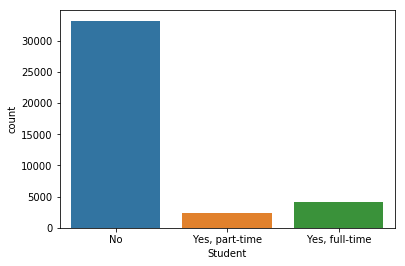

In [13]:
display(sns.countplot(new_results['Student']))

**Conclusion:** We see that most participants in the survey are not students.

Below, I'm visualizing the frequency of the values of the "FormalEducation" variable 

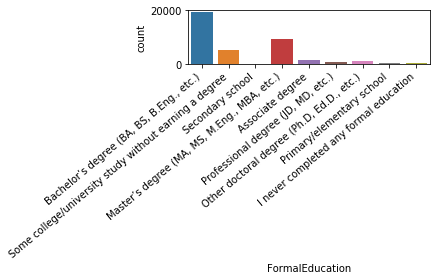

In [14]:
#Here, the reason why I explicitly define the labels is to limit the size of the labels for the plot
#we don't need to modify the labels in the dataframe, although we could if wanted.
ax = sns.countplot(new_results['FormalEducation'], order=['Bachelor’s degree (BA, BS, B.Eng., etc.)',
       'Some college/university study without earning a degree',
       'Secondary school',
       'Master’s degree (MA, MS, M.Eng., MBA, etc.)', 'Associate degree',
       'Professional degree (JD, MD, etc.)',
       'Other doctoral degree (Ph.D, Ed.D., etc.)',
       'Primary/elementary school',
       'I never completed any formal education'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

**Conclusion**: Most of the participants have either a Bachelor's degree or a Master's degree. Very few participants responded that they never completed any formal education.

Below, I'm visualizing the frequency of the values of the "YearsCoding" variable

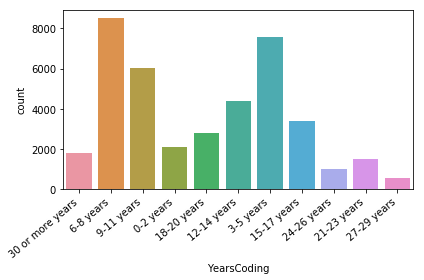

In [15]:
ax = sns.countplot(new_results['YearsCoding'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

**Conclusion**: A large number of participants have coding experience spanning 3-11 years. Analyzing the plot further, we see that most participants have about 6-8 years of coding experience.

Below, I'm visualizing the frequency of the values of the "CareerSatisfaction" variable

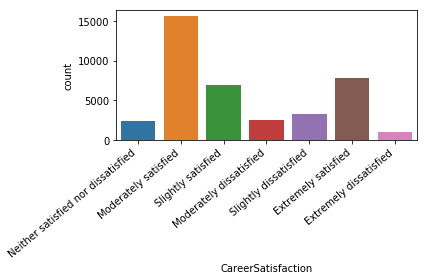

In [16]:
ax = sns.countplot(new_results['CareerSatisfaction'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

**Conclusion**: Questions that cause participants to reflect, such as the one corresponding to the CareerSatisfaction variable, can sometimes be hard to answer and analyze - it's challenging to pinpoint the exact reason(s) for the answers to these questions.

In this case, the definition of satisfaction with a career could be objective or subjective and dependent on numerous factors, such as field of interest, salary, proximity to workplace, etc. 

Most participants answered they are "moderately satisfied" with their job, and relatively few participants answered they were "extremely dissastified" with their job. 

Below, I'm visualizing the frequency of the values of the "DevType" variable, and I also print the value counts for each value class for this variable to clarify on the analysis.

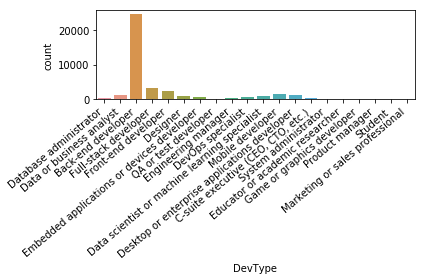

Back-end developer                               24525
Full-stack developer                              3396
Front-end developer                               2357
Mobile developer                                  1489
Desktop or enterprise applications developer      1406
Data or business analyst                          1191
Data scientist or machine learning specialist     1027
Designer                                           886
DevOps specialist                                  703
Embedded applications or devices developer         598
Database administrator                             530
C-suite executive (CEO, CTO, etc.)                 411
Engineering manager                                376
QA or test developer                               253
Educator or academic researcher                    179
Game or graphics developer                         163
System administrator                               108
Student                                             29
Product ma

In [17]:
ax = sns.countplot(new_results['DevType'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

new_results['DevType'].value_counts()

**Conclusion**: Most participants identify themselves as back-end developers, followed by full-stack developers and front-end developers. Very few participants identify themselves as marketing or sales professionals.

Below, I'm visualizing the frequency of the values of the "RaceEthnicity" variable, which is our protected attribute.

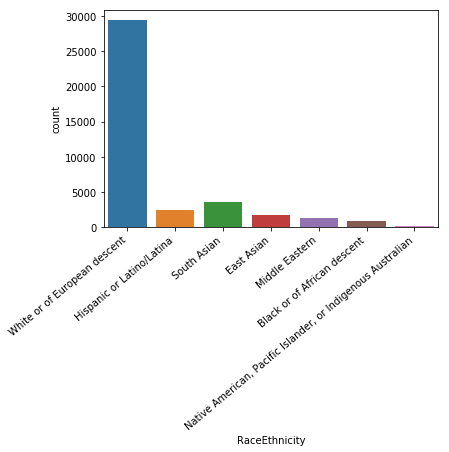

In [18]:
ax = sns.countplot(new_results['RaceEthnicity'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

**Conclusion**: 

We can see that the proportion of White participants who answered this survey is much larger compared to the number of participants from other races/ethnicities. **This highlights that the data is unrepresentative of populations from other races/ethnicities (a form of non-response bias).**

We also need to take into consideration that we deliberately removed additional selections from participants who chose to identify with more than one race/ethnicity, which might also be the reason why the dataset is so unrepresentative.

<div class="alert alert-warning">
<b>Toolkit Consideration:</b> 

The AIF360 toolkit does not mitigate non-response bias - label imbalance can sometimes not yield fairness issues, but the bias mitigation methods can mitigate bias regardless of class imbalance.

</div>

Finally, below, I'm visualizing the frequency of the values of the "ConvertedSalary" variable, which is the binary variable we are trying to predict.

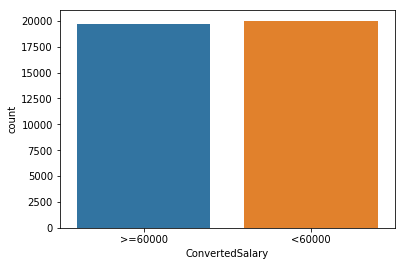

In [19]:
sns.countplot(new_results['ConvertedSalary'])

**Conclusion:**

We can see that the proportion of participants who earn below and above/equivalent to 60 K are almost equivalent, suggesting the data is representative in terms of the ConvertedSalary variable that we have engineered.

Now, we need to perform the one hot encoding of the columns; we can do so easily using pandas get_dummies() function.

## One-hot-encoding and data splitting

**Toolkit Consideration:**
    
For this project, we use a function of the toolkit that expects the predictor variable to be binary (I assume this "rule" applies for all variables that only hold two values, although in this case only ConvertedSalary is relevant). In this case, applying the pd.get_dummies() function to the ConvertedSalary function will result in two columns corresponding to the ConvertedSalary function, which is not expected, so I binarize the label manually based on whether a numerical value is greater than or less than 60 K.

In [20]:
tempdf = pd.get_dummies(new_results.iloc[:, :-1])

tempdf['ConvertedSalary'] = new_results['ConvertedSalary'].map({'>=60000': 1, '<60000': 0})

In [21]:
tempdf.head()

,Student_No,"Student_Yes, full-time","Student_Yes, part-time",FormalEducation_Associate degree,"FormalEducation_Bachelor’s degree (BA, BS, B.Eng., etc.)",FormalEducation_I never completed any formal education,"FormalEducation_Master’s degree (MA, MS, M.Eng., MBA, etc.)","FormalEducation_Other doctoral degree (Ph.D, Ed.D., etc.)",FormalEducation_Primary/elementary school,"FormalEducation_Professional degree (JD, MD, etc.)",...,DevType_Student,DevType_System administrator,RaceEthnicity_Black or of African descent,RaceEthnicity_East Asian,RaceEthnicity_Hispanic or Latino/Latina,RaceEthnicity_Middle Eastern,"RaceEthnicity_Native American, Pacific Islander, or Indigenous Australian",RaceEthnicity_South Asian,RaceEthnicity_White or of European descent,ConvertedSalary
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


Here, we note that for the ConvertedSalary variable, "1" represents '>=60000' and "0" represents '<60000'. Additionally, "1" represents "RaceEthnicity_White or of European descent" and "0" represents non-White.

Before we move on, we should note that the dataset has relatively (but not extremely) high cardinality - one-hot encoding variables can sometimes lead to redudancy in terms of features used as part of the dataset. We can try examining the correlations between the features to make sure there isn't any extreme multicollinearity in the dataset and whether we should drop any features from the dataset - below we see the correlation matrix displayed. 

Below, it seems that the highest correlations are between "Student No" and "Student Yes, full-time", and "Student No" and "Student Yes, part-time", so we drop the "Student Yes, full-time", and "Student Yes, part-time" variables from the dataset.

In [22]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

s = tempdf.corr().abs().unstack()
so = s.sort_values(kind="quicksort", ascending=False)
print(so[58:70])

#Uncomment the below line of code to see the full correlation matrix of all features in the dataset

#tempdf.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

Student_No                                                   Student_Yes, full-time                                         0.769468
Student_Yes, full-time                                       Student_No                                                     0.769468
Student_No                                                   Student_Yes, part-time                                         0.571051
Student_Yes, part-time                                       Student_No                                                     0.571051
FormalEducation_Master’s degree (MA, MS, M.Eng., MBA, etc.)  FormalEducation_Bachelor’s degree (BA, BS, B.Eng., etc.)       0.544234
FormalEducation_Bachelor’s degree (BA, BS, B.Eng., etc.)     FormalEducation_Master’s degree (MA, MS, M.Eng., MBA, etc.)    0.544234
RaceEthnicity_South Asian                                    RaceEthnicity_White or of European descent                     0.537354
RaceEthnicity_White or of European descent                   RaceEthn

In [23]:
#We drop the variables that are highly correlated from the dataset
tempdf = tempdf.drop(columns=['Student_Yes, full-time', 'Student_Yes, part-time'])
tempdf.head()

,Student_No,FormalEducation_Associate degree,"FormalEducation_Bachelor’s degree (BA, BS, B.Eng., etc.)",FormalEducation_I never completed any formal education,"FormalEducation_Master’s degree (MA, MS, M.Eng., MBA, etc.)","FormalEducation_Other doctoral degree (Ph.D, Ed.D., etc.)",FormalEducation_Primary/elementary school,"FormalEducation_Professional degree (JD, MD, etc.)","FormalEducation_Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",FormalEducation_Some college/university study without earning a degree,...,DevType_Student,DevType_System administrator,RaceEthnicity_Black or of African descent,RaceEthnicity_East Asian,RaceEthnicity_Hispanic or Latino/Latina,RaceEthnicity_Middle Eastern,"RaceEthnicity_Native American, Pacific Islander, or Indigenous Australian",RaceEthnicity_South Asian,RaceEthnicity_White or of European descent,ConvertedSalary
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
8,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1


Next, we can now apply the problem formalization to the data using the BinaryLabelDataset class offered by the AIF360 toolkit - the BinaryLabelDataset class allows us to take a normal pandas dataframe and convert it to a structure that the toolkit can use to calculate fairness metrics on.

Below, we specify the dataframe, label name, and values associated with certain advantages/disadvantages (salary higher than or lower than 60K), and the protected attribute names and values of the privileged/unprivileged groups in order to convert the normal pandas dataframe to a BinaryLabelDataset.

In [24]:
train_pp_bld = BinaryLabelDataset(df=tempdf, 
                                  label_names=['ConvertedSalary'],
                                  protected_attribute_names=['RaceEthnicity_White or of European descent'],
                                  favorable_label=1, #Having a salary greater than 60K
                                  unfavorable_label=0) #Having a salary lower than 60K

privileged_groups = [{'RaceEthnicity_White or of European descent': 1}] # White
unprivileged_groups = [{'RaceEthnicity_White or of European descent': 0}] #Not White

Next, we split the dataset into train (50%), validate (30%), and test (20%), as done in the AIF360 Toolkit Medical Expenditure tutorial (https://github.com/IBM/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb). 

In [25]:
(orig_train,
 orig_validate,
 orig_test) = train_pp_bld.split([0.5, 0.8], shuffle=True)

print("Training Dataset shape")
print(orig_train.features.shape)
print("Test Dataset shape")
print(orig_test.features.shape)
print("Validation Dataset shape")
print(orig_validate.features.shape)
print("Favorable and unfavorable outcome labels")
print(orig_train.favorable_label, orig_train.unfavorable_label)
print("Protected attribute names")
print(orig_train.protected_attribute_names)
print("Privileged and unprivileged protected attribute values")
print(orig_train.privileged_protected_attributes,
orig_train.unprivileged_protected_attributes)

Training Dataset shape
(19823, 55)
Test Dataset shape
(7930, 55)
Validation Dataset shape
(11894, 55)
Favorable and unfavorable outcome labels
1.0 0.0
Protected attribute names
['RaceEthnicity_White or of European descent']
Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]


## Analyzing metrics on original data 

Now, let's use the BinaryLabelDatasetMetric class from the toolkit to compute the fairness metric on the original training dataset.

In [26]:
metric_orig_train = BinaryLabelDatasetMetric(orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.235431


Before interpreting this further, we can access additional explanations from the BinaryLabelDataset Metric - I reuse the below two blocks of code below from Gareth Jones's Jupyter Notebook available here (https://github.com/garethjns/Kaggle-Titanic/blob/master/titanicsexism-fairness-in-ml.ipynb) to do so.

In [27]:
#credit:   https://github.com/garethjns/Kaggle-Titanic/blob/master/titanicsexism-fairness-in-ml.ipynb
from typing import Union

class MetricAdditions:
    def explain(self,
                disp: bool=True) -> Union[None, str]:
        """Explain everything available for the given metric."""

        # Find intersecting methods/attributes between MetricTextExplainer and provided metric.
        inter = set(dir(self)).intersection(set(dir(self.metric)))

        # Ignore private and dunder methods
        metric_methods = [getattr(self, c) for c in inter if c.startswith('_') < 1]

        # Call methods, join to new lines
        s = "\n".join([f() for f in metric_methods if callable(f)])

        if disp:
            print(s)
        else:
            return s
        
        
class MetricTextExplainer_(MetricTextExplainer, MetricAdditions):
    """Combine explainer and .explain."""
    pass

**Please Note**: The below block of code takes approximately or less than 5 minutes to run.

In [28]:
#credit:   https://github.com/garethjns/Kaggle-Titanic/blob/master/titanicsexism-fairness-in-ml.ipynb
# Create the explainer object
explainer = MetricTextExplainer_(metric_orig_train)
# Explain relevant metrics
explainer.explain()

Consistency (Zemel, et al. 2013): [0.65505726]
Statistical parity difference (probability of favorable outcome for unprivileged instances - probability of favorable outcome for privileged instances): -0.23543094588588465
Mean difference (mean label value on privileged instances - mean label value on unprivileged instances): -0.23543094588588465
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.5800212948617582
Number of positive-outcome instances: 9914.0
Number of instances: 19823.0
Number of negative-outcome instances: 9909.0


<div class="alert alert-info">
<b>Relevant Metrics Explanation:</b> 

<br />

**Statistical Parity Difference** - This is the difference in the probability of favorable outcomes between the unprivileged and privileged groups. A value of 0 implies both groups have equal beneﬁt, a value less than 0 implies higher beneﬁt for the privileged group, and a value greater than 0 implies higher beneﬁt for the unprivileged group.

<br />


**Disparate Impact** - This is the ratio in the probability of favorable outcomes between the unprivileged and privileged groups. A value of 1 implies both groups have equal beneﬁt, a value less than 1 implies higher beneﬁt for the privileged group, and a value greater than 1 implies higher beneﬁt for the unprivileged group.

<br />

**Consistency**: An individual fairness metric that "assesses the consistency of the model’s classification prediction of a given data item x to its k-nearest neighbors; values close to one indicate that similar inputs are treated similarly." - Taken from "Learning Fair Representations" (https://www.cs.toronto.edu/~toni/Papers/icml-final.pdf).

<br />

Citation: The above information is taken from the "AI Fairness 360: An Extensible Toolkit for Detecting, Understanding, and Mitigating Unwated Algorithmic Bias" (https://arxiv.org/pdf/1810.01943.pdf) paper and modified.

</div>

We see the Statistical parity difference is approximately -0.24 - White individuals are getting 24% percent more positive outcomes in terms of higher salary compared to non-White individuals; we see less favorable outcomes for the unprivileged group. In terms of disparate impact, we see the value is approximately 0.58, which implies higher benefit for White individuals.

Now that we've assessed the bias of the dataset, we can apply the re-weighing algorithm to try to mitigate it.

## Pre-Processing algorithms: Reweighing

Reweighing involves weighting the examples in each (group, label) combination differently to ensure fairness before classification.

The authors state reweighing can be seen as a form of cost-sensitive learning. Objects with higher weights result in errors for the object becoming more expensive.

The advantages of this algorithm: There is no need to change any of the labels, and the goal is to maintain overall positive class probability but also reduce the discrimination.

The constraint of this algorithm: The learner needs to be able to work with weighted tuples.

A relevant paragraph from this paper:

![image.png](https://gist.githubusercontent.com/riacheruvu/6af470459018959db6e6a69d1e5294ee/raw/bf7e8d46bfa14f09c0c7b438e7894b6950c5d30d/image.png)

(Kamiran & Calders, 2011, p. 17). 

Before we apply the algorithm, let's extract values of the protected attribute and the instance weights from the original dataset:

In [41]:
orig_protected_attributes = list(orig_train.protected_attributes)
orig_instance_weights = list(orig_train.instance_weights)
orig_labels = list(orig_train.labels)
orig_weights = pd.DataFrame(
    {'orig_protected_attributes': orig_protected_attributes,
     'orig_instance_weights': orig_instance_weights,
     'orig_labels': orig_labels
    })
orig_weights.head()

,orig_instance_weights,orig_labels,orig_protected_attributes
0,1.0,[0.0],[1.0]
1,1.0,[0.0],[0.0]
2,1.0,[1.0],[1.0]
3,1.0,[1.0],[1.0]
4,1.0,[1.0],[1.0]


In [42]:
print(orig_weights.iloc[319])
print(orig_weights.iloc[428])
print(orig_weights.iloc[455])
print(orig_weights.iloc[991])

orig_instance_weights            1
orig_labels                  [1.0]
orig_protected_attributes    [1.0]
Name: 319, dtype: object
orig_instance_weights            1
orig_labels                  [1.0]
orig_protected_attributes    [1.0]
Name: 428, dtype: object
orig_instance_weights            1
orig_labels                  [1.0]
orig_protected_attributes    [1.0]
Name: 455, dtype: object
orig_instance_weights            1
orig_labels                  [0.0]
orig_protected_attributes    [0.0]
Name: 991, dtype: object


Now, let's apply the reweighing algorithm and inspect the instance weights. Note, we only apply the reweighing algorithm for the training dataset, as we need to keep the original validation and test datasets similar to what is done for the Medical Expenditure tutorial.

In [43]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(orig_train)

In [44]:
reweighed_protected_attributes = list(dataset_transf_train.protected_attributes)
reweighed_instance_weights = list(dataset_transf_train.instance_weights)
reweighed_labels = list(orig_train.labels)
reweighed_weights = pd.DataFrame(
    {'reweighed_protected_attributes': reweighed_protected_attributes,
     'reweighed_instance_weights': reweighed_instance_weights,
     'orig_instance_weights': orig_instance_weights,
     'reweighed_labels': reweighed_labels
    })
reweighed_weights.head()

,orig_instance_weights,reweighed_instance_weights,reweighed_labels,reweighed_protected_attributes
0,1.0,1.137572,[0.0],[1.0]
1,1.0,0.740716,[0.0],[0.0]
2,1.0,0.892161,[1.0],[1.0]
3,1.0,0.892161,[1.0],[1.0]
4,1.0,0.892161,[1.0],[1.0]


In [45]:
print(reweighed_weights.iloc[319])
print(reweighed_weights.iloc[428])
print(reweighed_weights.iloc[455])
print(reweighed_weights.iloc[991])

orig_instance_weights                    1
reweighed_instance_weights        0.892161
reweighed_labels                     [1.0]
reweighed_protected_attributes       [1.0]
Name: 319, dtype: object
orig_instance_weights                    1
reweighed_instance_weights        0.892161
reweighed_labels                     [1.0]
reweighed_protected_attributes       [1.0]
Name: 428, dtype: object
orig_instance_weights                    1
reweighed_instance_weights        0.892161
reweighed_labels                     [1.0]
reweighed_protected_attributes       [1.0]
Name: 455, dtype: object
orig_instance_weights                    1
reweighed_instance_weights        0.740716
reweighed_labels                     [0.0]
reweighed_protected_attributes       [0.0]
Name: 991, dtype: object


We can see the re-weighing algorithm assigns lest weight to instances where the protected attribute == 1.0, or for the privileged group, and where the label == 1.0 (salary greater than 60K). It also assigns more weight to instances where the protected attribute == 0.0, or for the unprivileged group, and where the label == 1.0 (salary greater than 60K). In other words, my intrepretation of this is that examples of White individuals who have a salary greater than 60K or downweighted, and examples of non-White individuals who have a salary greater than 60K are upweighted. Additionally, non-White individuals who have salary lower than 60K are downweighted.

Now, we can evaluate whether the re-weighing algorithm succesfuly eliminated the bias.

In [47]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


It seems the mitigation step was effective, as the difference in mean outcomes is equal to 0.

Now, let's try training, validating, and testing ML algorithms on the original and transformed data.

## Train/test ML algorithms on original and transformed data to evaluate effects of fairness on predictive accuracy

I'd like to note that for this section, I heavily draw upon code from the AIF360 "Medical Expenditure Tutorial" (https://github.com/IBM/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb). This is because the BinaryLabelDataset is not a regular pandas dataframe, and requires custom code in order to train a sklearn model with it and access the fairness metrics. 

Furthermore, I'd like to note that the goal of this section is not to tune the machine learning model, which is outside of the scope of this project. The goal is to analyze fairness metrics of the models' predictions and try to mitigate bias using the transformed dataset.

I combine the code related to training and validating the model in one code block to not prolong the length of this notebook.

### Training on original data

#### Logistic Regression

First, we train a Logistic Regression model on the original dataset, and then we test the model on the validation dataset. In addition to testing the performance of the model on the validation dataset, validating the model is also useful because we can determine the optimal classification threshold for the best accuracy - the scikit-learn model outputs probabilities and using a default threshold of 0.5 (if a probability value is greater than 0.5, assign the output to "1", else assign to "0") is not always practical. 

To make sense of the variables defined in the above code, we can observe the visual results of the algorithms. I reuse helpful code from Nathan Lauga's kernel (https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml) to output metrics, a confusion matric, and a ROC curve to analyze.

In [56]:
#Credit - code taken from and modified: https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml
def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc

def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    print('Accuracy:', accuracy)
    print('F1 score:', f1)

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")

Before training and validating, we define some helper functions. An important aspect to point out in the below code is the use of the ClassificationMetric() function offered by the AIF360 tookkit, which is used to compute metrics on two BinaryLabelDatasets (one of which is the original, and the other is the output of the classifier).

In [50]:
#credit: Taken from tutorial_medical_expenditure.ipynb
def test(dataset, model, thresh_arr):
    try:
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'disparate impact' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))
     

Accuracy: 0.7006053472338994
F1 score: 0.6973225669358266
Threshold corresponding to Best balanced accuracy: 0.4600
Best balanced accuracy: 0.7025
Corresponding 1-min(DI, 1/DI) value: 0.6525
Corresponding average odds difference value: -0.3665
Corresponding statistical parity difference value: -0.4365
Corresponding equal opportunity difference value: -0.3976
Corresponding Theil index value: 0.1744


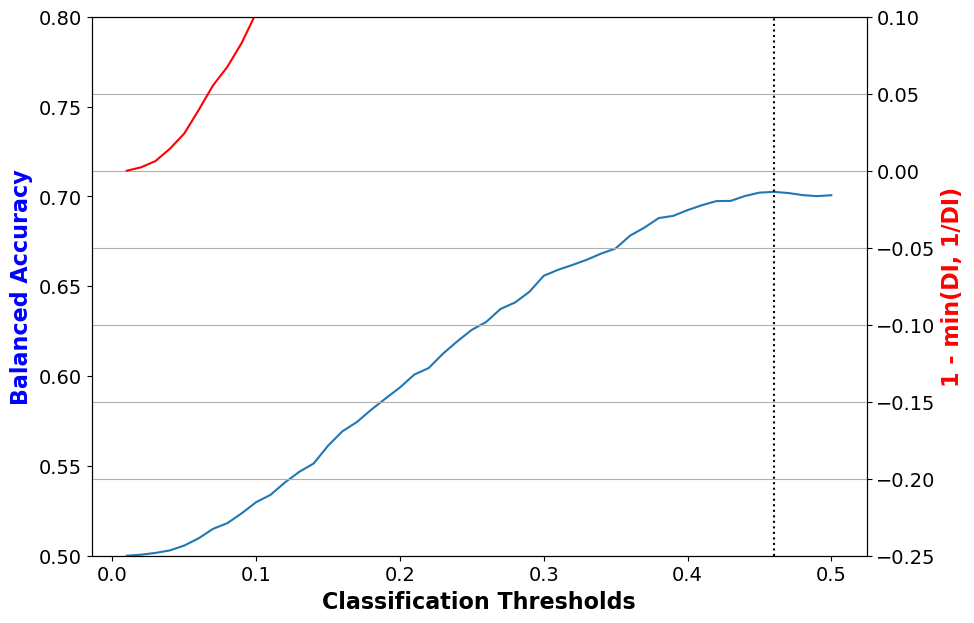

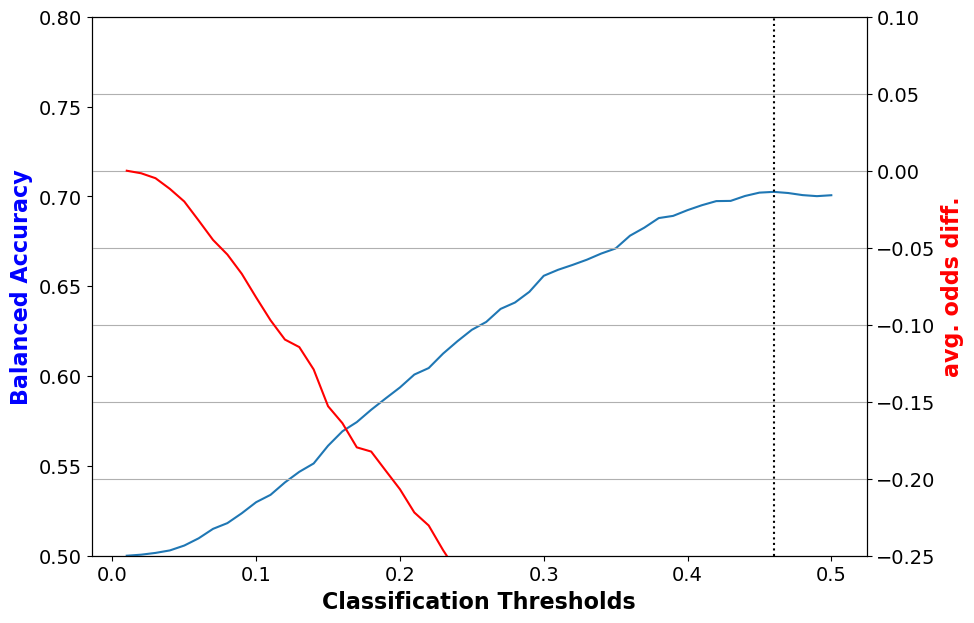

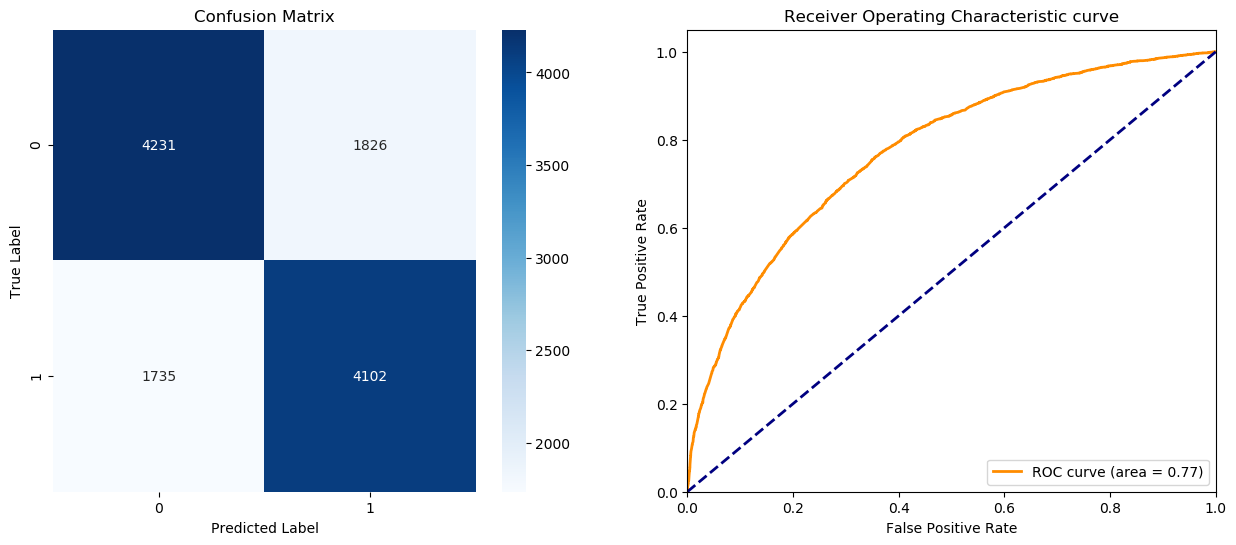

In [67]:
#adopted and modified from tutorial_medical_expenditure.ipynb

###########Training###########
dataset = orig_train
#We could just use the sklearn LogisticRegression() classifier directly, but we utilize make_pipeline() as done
#in the medical expenditure tutorial, as it makes it easier to add in numerical variables, and apply a StandardScaler()

model = make_pipeline(LogisticRegression(solver='liblinear', random_state=1)) 
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

LR_model = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)
###########Training###########


###########Validation###########

thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=orig_validate,
                   model=LR_model,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')
     
plot_model_performance(LR_model, orig_validate.features, orig_validate.labels)
describe_metrics(val_metrics, thresh_arr)
###########Validation###########

<div class="alert alert-info">
<b>Metrics Explanation:</b> 

<br />


**Balanced accuracy** - Balanced accuracy is used to "avoid inflated performance estimates on imbalanced datasets... In the binary case, balanced accuracy is equal to the arithmetic mean of sensitivity (true positive rate) and specificity (true negative rate), or the area under the ROC curve with binary predictions rather than scores." - Taken from Scikit-Learn's documentation on model evaluation (https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score).

<br />


**Average odds difference** - This is the average of difference in false positive rates and true positive rates between unprivileged and privileged groups. A value of 0 implies both groups have equal beneﬁt, a value less than 0 implies higher beneﬁt for the privileged group and a value greater than 0 implies higher beneﬁt for the unprivileged group.

<br />

**Equal opportunity difference** - This is the difference in true positive rates between unprivileged and privileged groups. A value of 0 implies both groups have equal beneﬁt, a value less than 0 implies higher beneﬁt for the privileged group and a value greater than 0 implies higher beneﬁt for the unprivileged group.

<br />

**Statistical Parity Difference** - This is the difference in the probability of favorable outcomes between the unprivileged and privileged groups. A value of 0 implies both groups have equal beneﬁt, a value less than 0 implies higher beneﬁt for the privileged group, and a value greater than 0 implies higher beneﬁt for the unprivileged group.

<br />

**Disparate Impact** - This is the ratio in the probability of favorable outcomes between the unprivileged and privileged groups. A value of 1 implies both groups have equal beneﬁt, a value less than 1 implies higher beneﬁt for the privileged group, and a value greater than 1 implies higher beneﬁt for the unprivileged group. Here 1- min(disparate impact, 1 / disparate impact) or 1-min(DI, 1/DI) is used for the plotting. In the AIF360 toolkit tutorials, 1 - min(disparate impact, 1/disparate impact) or 1-min(DI, 1/DI) is used and the goal is to make sure this metric is less than 0.2, since in the authors' words, "it's possible to overcorrect and end up with a value greater than 1, implying unfairness for the original privileged group" - taken from https://github.com/IBM/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb.

<br />

**Theil index**: - "The Theil index is a statistic primarily used to measure economic inequality and other economic phenomena, though it has also been used to measure racial segregation. The Theil index TT is the same as redundancy in information theory which is the maximum possible entropy of the data minus the observed entropy." Taken from https://en.wikipedia.org/wiki/Theil_index


<br />

Citation: The below information is taken from the "AI Fairness 360: An Extensible Toolkit for Detecting, Understanding, and Mitigating Unwated Algorithmic Bias" (https://arxiv.org/pdf/1810.01943.pdf) paper and modified.


</div>

**Analyzing model metrics**: We see the accuracy of the algorithm is approximately 70% and the F1-score is also approximately 70%. From the confusion matrix, we see more false positives compared to false negatives, but nothing too alarming.

An interesting question associated with the problem formlization is whether false positives (indicating a condition doesn't hold, when it does) or false negatives (indicating a condition does hold, when it doesn't) has more cost. It could be said that classifying an individual as having a salary of more than 60K, when they really have less, is more important to consider, compared to an individual not having a salary of more than 60K, when they really have more - although this depends on the application (e.g. assigning employee benefits based on salary).

**Analyzing fairness metrics**: Statistical parity difference, average odds difference, and the equal opportunity difference value all indicate that there is a higher benefit for the privileged group (represented by the low values with the negative sign). Furthermore, the Theil index has a high value, indicating the original dataset does not have much fairness.

Also, the 1-min(DI, 1/DI) value should typically be less than 0.2 for the classifier predictions to be fair, but in this case we see they are not.

**Clasification Threshold**: We see the best classification threshold seems to be 0.46 - as demonstrated at the plots, at this point, we see balanced accuracy is relatively high, however, we see average odds difference is not close to 0 and abs(1-disparate impact) is not close to being less than 0.2.

We see the best classification threshold seems to be 0.46 - as demonstrated at the plots. We also see that while balanced accuracy increases, average odds difference decreases to values lower than 0.00, suggesting there is a contention between these two values reaching a successful threshold for this particular situation/code run. In this particular case, we also see balanced accuracy improving as 1-min(DI, 1/DI) reaches a value of greater 0 (it might increase past a value of 0.2) suggesting this is might be an optimal threshold value and reweighing could be useful, as striking a balance between the two metrics seems to be relatively challenging with the original data. These results vary from run to run.

It's time to run the algorithm on the test dataset.

Accuracy: 0.6972257250945776
F1 score: 0.697873411350195
Threshold corresponding to Best balanced accuracy: 0.4600
Best balanced accuracy: 0.6938
Corresponding 1-min(DI, 1/DI) value: 0.6606
Corresponding average odds difference value: -0.3737
Corresponding statistical parity difference value: -0.4483
Corresponding equal opportunity difference value: -0.3936
Corresponding Theil index value: 0.1755


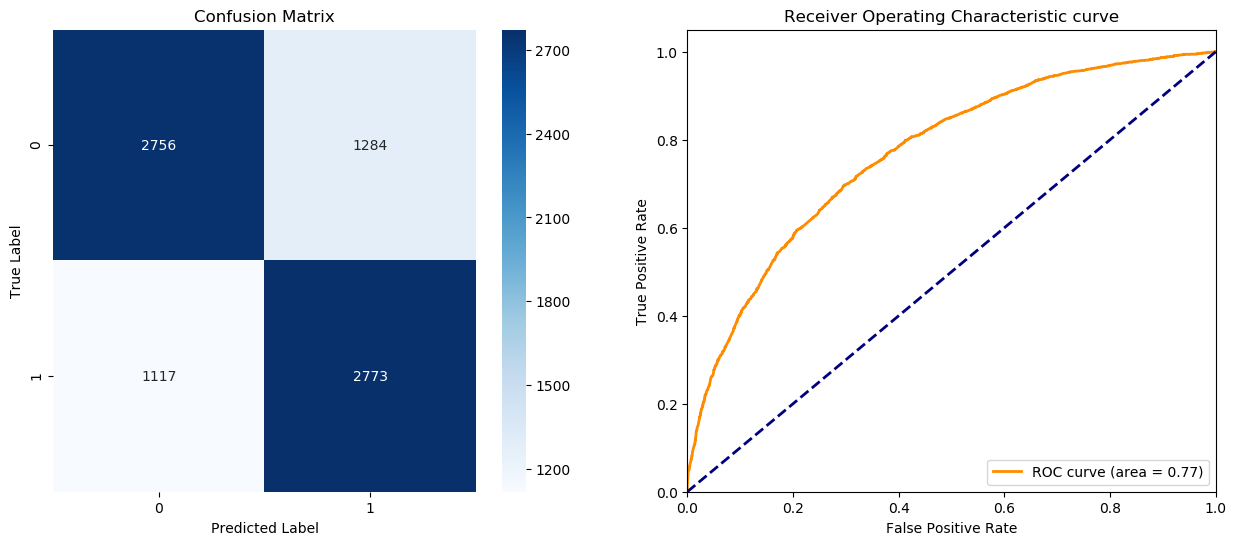

In [68]:
#adopted and modified from tutorial_medical_expenditure.ipynb
###########Test###########

lr_orig_metrics = test(dataset=orig_test,
                       model=LR_model,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

plot_model_performance(LR_model, orig_test.features, orig_test.labels)
describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])
###########Test###########

The model seems to be doing relatively good at accuracy, maintaining relatively the same performance for both the validation and test datasets (relatively equivalent accuracy of approximately 70%). The analysis we performed for the validation dataset holds here as well - according to metrics like the statistical parity difference and 1-min(DI, 1/DI) value (which have slightly increased compared to the validation dataset), the predictions made by the classifier are not fair.

#### Random Forest

Next, we train a Random Forest model on the original dataset, and then we test the model on the validation dataset. Since we defined our helper functions in the above section, we can dive into the implementation.

For the purposes of this project, we use the default arguments provided in the tutorial_medical_expenditure.ipynb - the number of trews is set to 500 and the minimum number of samples required to be a leaf node is 25. If our goal was to build the best machine learning model, we could tune these parameters extensively and evaluate their influence on accuracy and fairness metrics.

Accuracy: 0.6966537750126114
F1 score: 0.6910429868128104
Threshold corresponding to Best balanced accuracy: 0.5000
Best balanced accuracy: 0.6966
Corresponding 1-min(DI, 1/DI) value: 0.8093
Corresponding average odds difference value: -0.4542
Corresponding statistical parity difference value: -0.5049
Corresponding equal opportunity difference value: -0.5410
Corresponding Theil index value: 0.2101


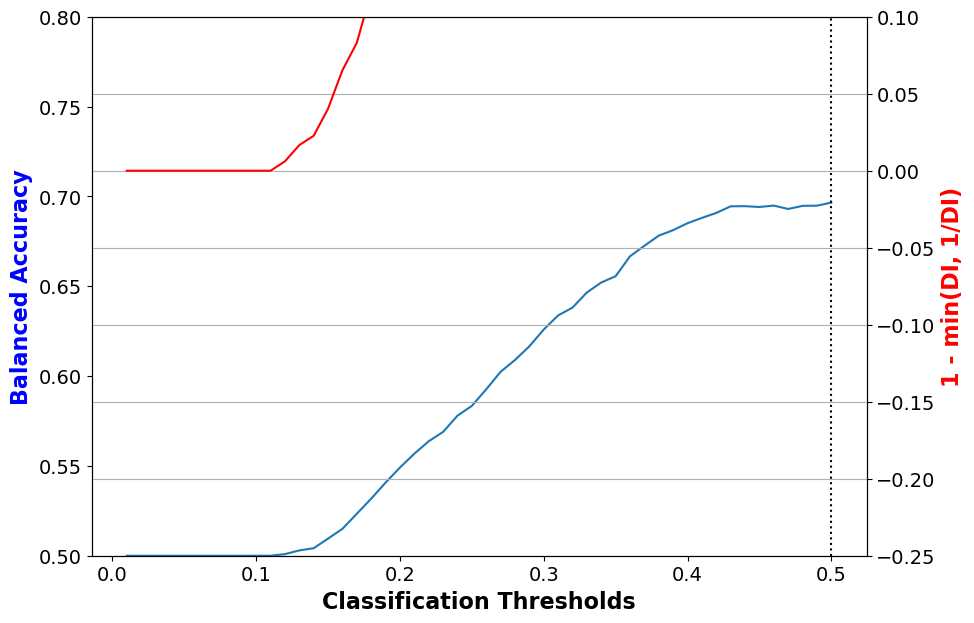

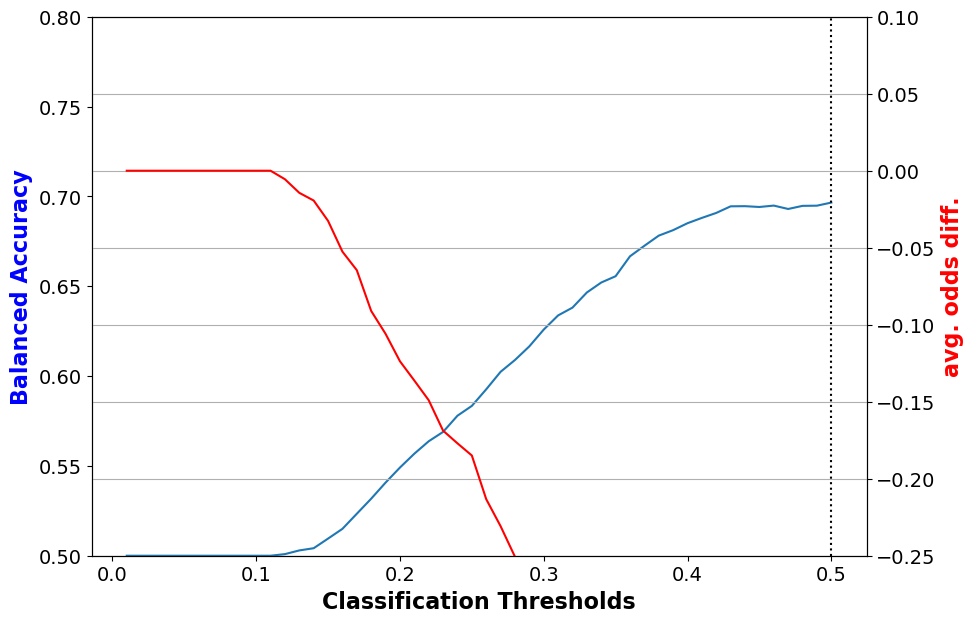

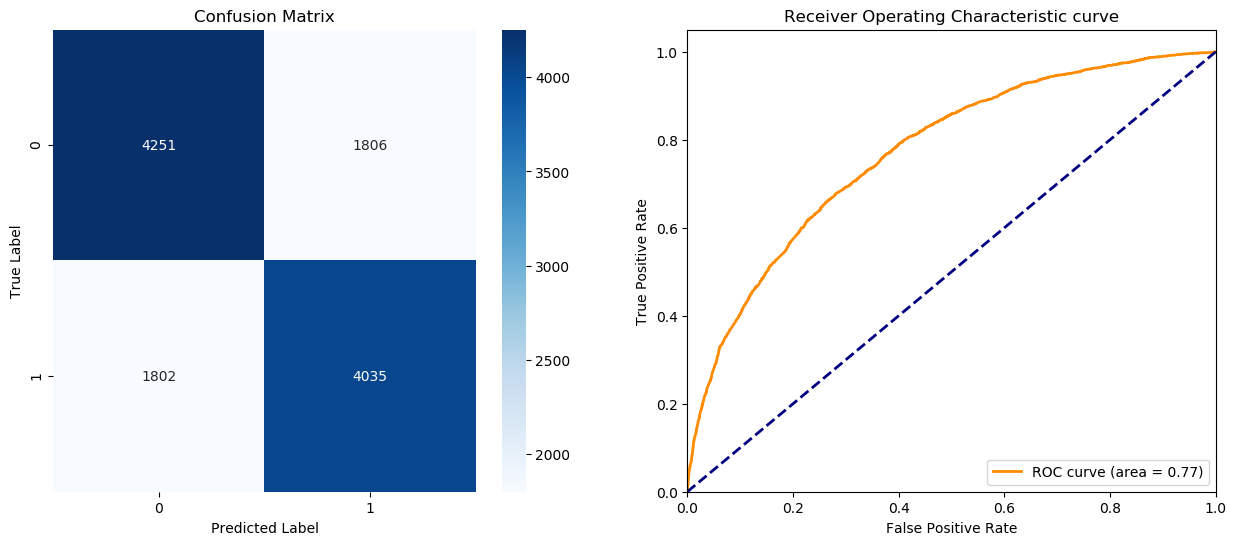

In [69]:
#adopted and modified from tutorial_medical_expenditure.ipynb
###########Training###########

dataset = orig_train
model = make_pipeline(RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
RF_model = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)
###########Training###########

###########Validation###########

thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=orig_validate,
                   model=RF_model,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

plot_model_performance(RF_model, orig_validate.features, orig_validate.labels)

describe_metrics(val_metrics, thresh_arr)
###########Validation###########

**Analyzing model metrics**: We see the accuracy and F1 scpre of the algorithm is approximately 70%. From the confusion matrix, we see more false positives compared to false negatives. The metrics are extremely similar to what we obtained for logistic regression, but there are differences in the metrics - we'll also see differences in the variable importance as well.

**Analyzing fairness metrics**: We see similar results as we did with logistic regression: Statistical parity difference, average odds difference, and the equal opportunity difference value all indicate that there is a higher benefit for the privileged group (represented by the low values with the negative sign). Furthermore, all of these values seem to be more distant from the "fair threshold" of 0 for Random Forst, compared to Logistic Regression.

Furthermore, the Theil index has a high value, indicating the original dataset does not have much fairness.

Also, 1-min(DI, 1/DI) value should typically be less than 0.2 for the classifier predictions to be fair, but in this case we see they are not - the 1-min(DI, 1/DI) value obtained for the Random Forest is much larger compared to the one for Logistic Regression.

**Clasification Threshold**: We see the best classification threshold seems to be 0.5 - as demonstrated at the plots, at this point, we see balanced accuracy is relatively high, we see 1-min(DI, 1/DI) might not be close to being less than 0.2. We also see that while balanced accuracy increases, average odds difference decreases lower than 0.00, suggesting (similar to logistic regression) that there is a contention between these two values reaching a successful threshold.

We see similar results on the test dataset below:

Accuracy: 0.69281210592686
F1 score: 0.6910197869101978
Threshold corresponding to Best balanced accuracy: 0.5000
Best balanced accuracy: 0.6930
Corresponding 1-min(DI, 1/DI) value: 0.8032
Corresponding average odds difference value: -0.4528
Corresponding statistical parity difference value: -0.5100
Corresponding equal opportunity difference value: -0.5221
Corresponding Theil index value: 0.2061


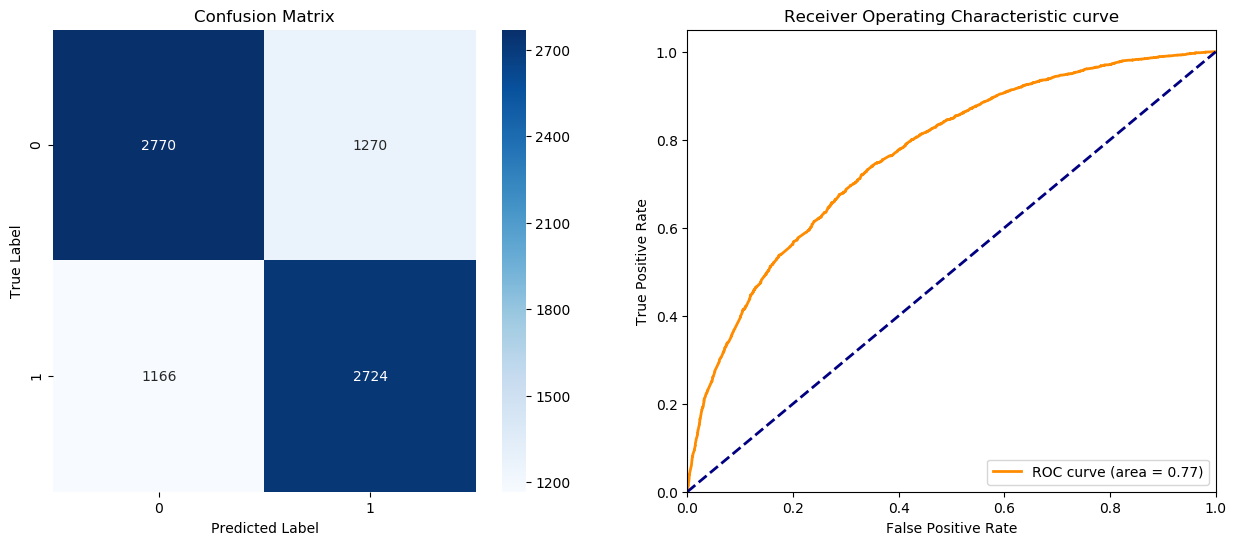

In [71]:
#adopted and modified from tutorial_medical_expenditure.ipynb
###########Test###########

rf_orig_metrics = test(dataset=orig_test,
                       model=RF_model,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])

plot_model_performance(RF_model, orig_test.features, orig_test.labels)
describe_metrics(rf_orig_metrics, [thresh_arr[rf_orig_best_ind]])
###########Test###########

Again, we see the interpretation we performed for the validation dataset is applicable here - the classifier's predictions are not fair, and can be seen as more biased compared to the results obtained for Logistic Regression.

#### Comparisons between the models

Now, let's look at the feature importance associated with the different models on the training dataset. I reuse the following helpful code from https://www.kaggle.com/garethjns/titanicsexism-fairness-in-ml#Fairness-metrics to plot the feature importance for the random forest and logistic regression models.

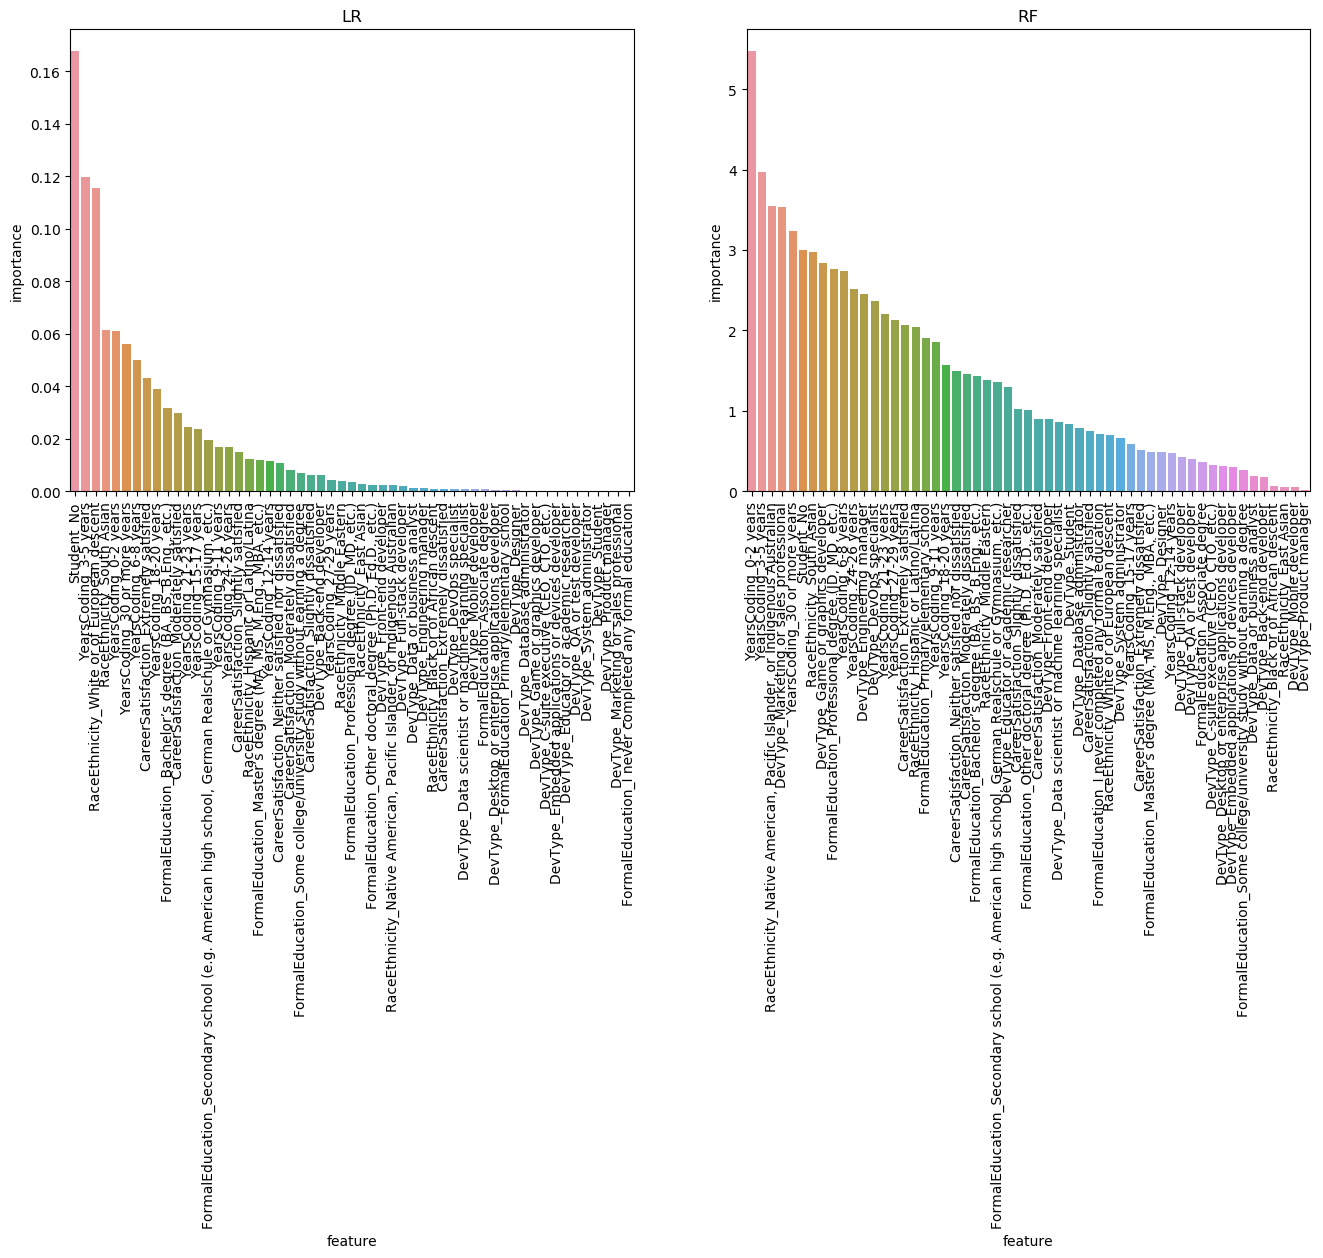

In [74]:
#credit: https://www.kaggle.com/garethjns/titanicsexism-fairness-in-ml#Fairness-metrics
    
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier],
                       names: List[str],
                       scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if 'LogisticRegression' in str(mod.named_steps):
        mod = mod.named_steps['logisticregression']
        imp = np.abs(mod.coef_.squeeze()) / scale 
        var = np.zeros(shape=imp.shape)
    elif 'RandomForest' in str(mod.named_steps):
        mod = mod.named_steps['randomforestclassifier']
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)
        
    return pd.DataFrame({'feature': names,
                         'importance': imp,
                         'std': var}).sort_values('importance',
                                                  ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)
        
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))

plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(LR_model,
                                                names=orig_train.feature_names,  
                                                scale=orig_train.features.std()), ax=ax[1])
_ = ax[0].set_title('LR')


plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(RF_model,
                                                names=orig_train.feature_names,  
                                                scale=orig_train.features.std()), ax=ax[0])
_ = ax[1].set_title('RF')


We see some interesting results, which I summarize below:

- For the Logistic regression variable, not being a student seems to be the variable with the highest importance. For the Random Forest model, coding for 0-2 years seems to be the variable with the highest importance.

- In terms of race, for the logistic regression model, the raceethnicity variable corresponding to White or European descent seems to be an important variable, whereas for the random forest model, the RaceEthnicity variable corresponding to Native American, Pacific Islander, or Indigenous Australian seems to have more variable importance for predicting whether salary is above/equivalent to 60K or below 60k.

- Some of the variables that have the lowest variable importance for both models are being extremely dissatisfied with your career, never completing any formal education, and certain values of the DevType variable, such as being a back-end developer.


The point on the variable corresponding to Native American, Pacific Islander, or Indigenous Australian having more variable importance is interesting - we can try quickly creating a BinaryLabelDataset where being Native American makes you privileged.

In [73]:
#Does it make sense to include the other RaceEthnicity_* variables? 

NA_train_pp_bld = BinaryLabelDataset(df=tempdf,
                                  label_names=['ConvertedSalary'],
                                  protected_attribute_names=['RaceEthnicity_Native American, Pacific Islander, or Indigenous Australian'],
                                  favorable_label=1, #Having a salary greater than 60K
                                  unfavorable_label=0) #Having a salary lower than 60K

#RaceEthnicity_White or of European descent

NA_privileged_groups = [{'RaceEthnicity_Native American, Pacific Islander, or Indigenous Australian': 1}] #Native American
NA_unprivileged_groups = [{'RaceEthnicity_Native American, Pacific Islander, or Indigenous Australian': 0}] #Native American

NA_metric_transf_train = BinaryLabelDatasetMetric(NA_train_pp_bld, 
                                               unprivileged_groups=NA_unprivileged_groups,
                                               privileged_groups=NA_privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % NA_metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.180628


The value of the difference in mean outcomes is negative, suggesting that privileged groups (individuals who are Native American, Pacific Islanders, or Indigenous Australians) have higher beneﬁt in terms of higher salary - our variable importance plots for Random Forest were able to reveal this important quality of the dataset that can be used for drawing up future problem formalizations.

### Results on the reweighed dataset 

#### Logistic Regression

Now, we train a logistic regression model on the reweighed dataset using the same approach as before. As noted before, the reweighing transformation is only performed on the training dataset - the validation and test datasets are left as is.

Accuracy: 0.6828653102404574
F1 score: 0.6808258588593671
Threshold corresponding to Best balanced accuracy: 0.5000
Best balanced accuracy: 0.6830
Corresponding 1-min(DI, 1/DI) value: 0.1944
Corresponding average odds difference value: -0.0277
Corresponding statistical parity difference value: -0.1030
Corresponding equal opportunity difference value: -0.0556
Corresponding Theil index value: 0.2134


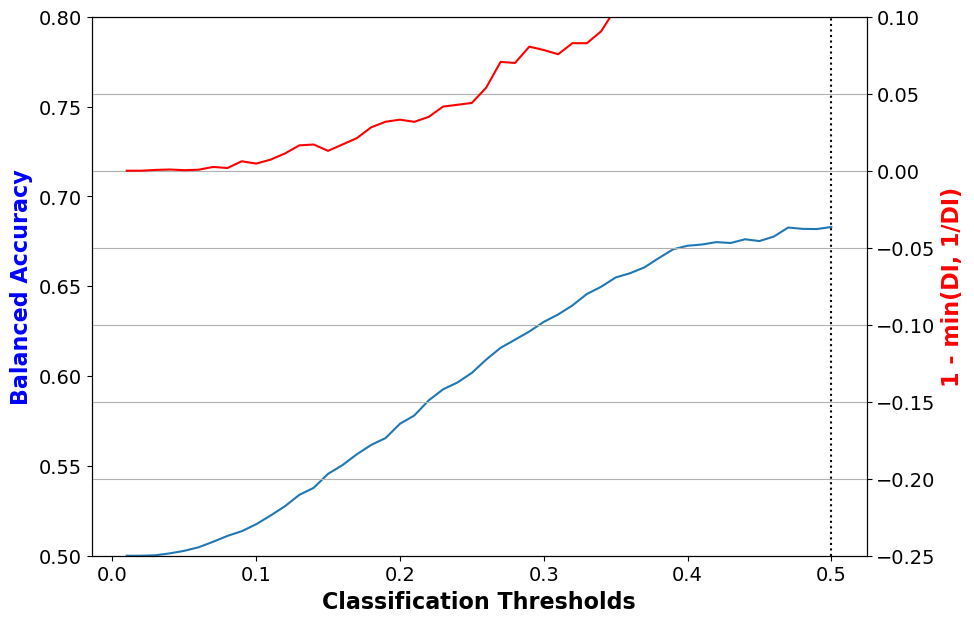

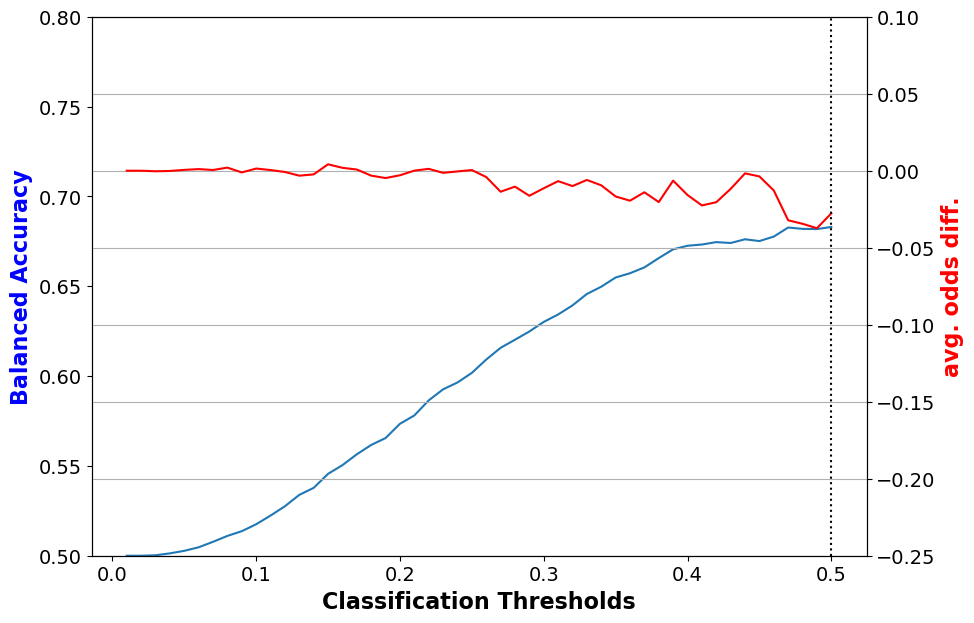

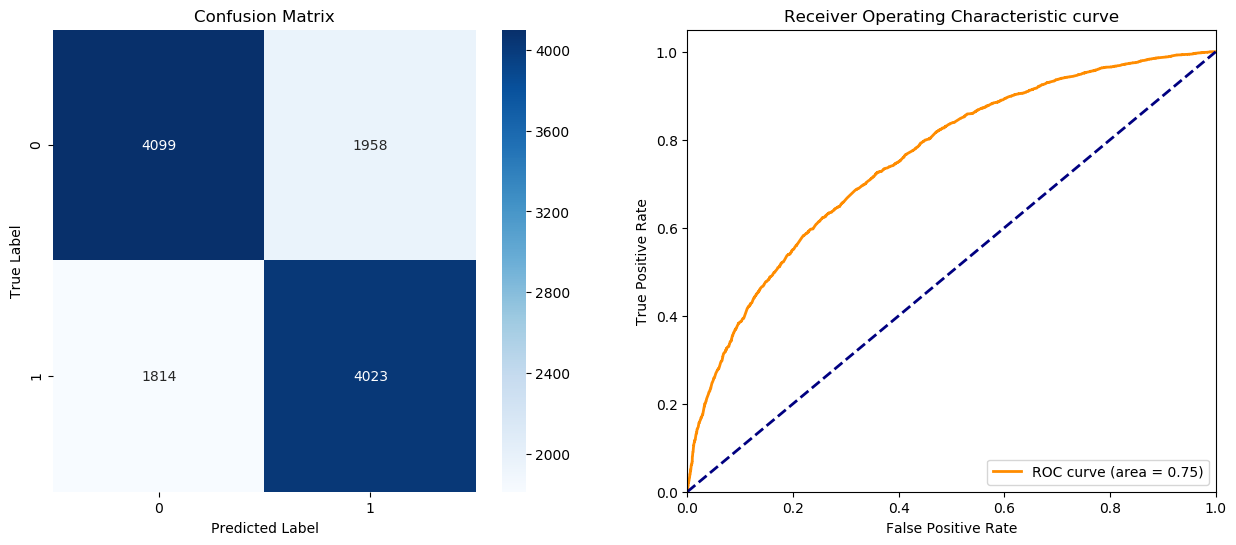

In [77]:
#adopted and modified from tutorial_medical_expenditure.ipynb

###########Training###########

dataset = dataset_transf_train
model = make_pipeline(LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
LR_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)
###########Training###########

###########Validation###########

thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=orig_validate,
                   model=LR_transf,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')


plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

plot_model_performance(LR_transf, orig_validate.features, orig_validate.labels)
describe_metrics(val_metrics, thresh_arr)
###########Validation###########

<div class="alert alert-info">
<b>Metrics Explanation:</b> 

<br />

**Balanced accuracy** - Balanced accuracy is used to "avoid inflated performance estimates on imbalanced datasets... In the binary case, balanced accuracy is equal to the arithmetic mean of sensitivity (true positive rate) and specificity (true negative rate), or the area under the ROC curve with binary predictions rather than scores." - Taken from Scikit-Learn's documentation on model evaluation (https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score).

<br />

**Average odds difference** - This is the average of difference in false positive rates and true positive rates between unprivileged and privileged groups. A value of 0 implies both groups have equal beneﬁt, a value less than 0 implies higher beneﬁt for the privileged group and a value greater than 0 implies higher beneﬁt for the unprivileged group.

<br />

**Equal opportunity difference** - This is the difference in true positive rates between unprivileged and privileged groups. A value of 0 implies both groups have equal beneﬁt, a value less than 0 implies higher beneﬁt for the privileged group and a value greater than 0 implies higher beneﬁt for the unprivileged group.

<br />

**Statistical Parity Difference** - This is the difference in the probability of favorable outcomes between the unprivileged and privileged groups. A value of 0 implies both groups have equal beneﬁt, a value less than 0 implies higher beneﬁt for the privileged group, and a value greater than 0 implies higher beneﬁt for the unprivileged group.

<br />

**Disparate Impact** - This is the ratio in the probability of favorable outcomes between the unprivileged and privileged groups. A value of 1 implies both groups have equal beneﬁt, a value less than 1 implies higher beneﬁt for the privileged group, and a value greater than 1 implies higher beneﬁt for the unprivileged group. In the AIF360 toolkit tutorials, 1 - min(disparate impact, 1/disparate impact) or 1-min(DI, 1/DI) is used and the goal is to make sure this metric is less than 0.2, since in the authors' words, "it's possible to overcorrect and end up with a value greater than 1, implying unfairness for the original privileged group" - taken from https://github.com/IBM/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb.

<br />

**Theil index**: - "The Theil index is a statistic primarily used to measure economic inequality and other economic phenomena, though it has also been used to measure racial segregation. The Theil index TT is the same as redundancy in information theory which is the maximum possible entropy of the data minus the observed entropy." Taken from https://en.wikipedia.org/wiki/Theil_index

<br />

Citation: The below information is taken from the "AI Fairness 360: An Extensible Toolkit for Detecting, Understanding, and Mitigating Unwated Algorithmic Bias" (https://arxiv.org/pdf/1810.01943.pdf) paper and modified.


</div>


**Analyzing model metrics**: We see the accuracy and F1-score of the algorithm is now approximately 68%, which is lower than the original performance. We see similar results with the confusion matrix as well. We do note that the balanced accuracy has now reduced to 68%, suggesting re-weighing does have an impact on the balanced accuracy. 

**Analyzing fairness metrics**: We see a **significant** (difference in the statistical parity difference, average odds difference, the equal opportunity difference value, and the 1-min(DI, 1/DI) values which are now all much closer to 0). The Theil index still has a higher value, however, which would indicate the original dataset does not have much fairness.

Restating the point, the 1-min(DI, 1/DI) value is now less than 0.2, so according to this metric, the classifier predictions are fair.

**Clasification Threshold**: We see the best classification threshold seems to be 0.5 - as demonstrated at the plots, at this point, we see balanced accuracy is relatively high, and even though 1-min(DI, 1/DI) rises at that threshold value, it is not greater than 0.2. We see that average odds difference value does not increase higher than 0 at a classification threshold of 0.5.

Now, let's see the results on the test datset.

Accuracy: 0.6779319041614124
F1 score: 0.6781754032258065
Threshold corresponding to Best balanced accuracy: 0.5000
Best balanced accuracy: 0.6782
Corresponding 1-min(DI, 1/DI) value: 0.2108
Corresponding average odds difference value: -0.0288
Corresponding statistical parity difference value: -0.1137
Corresponding equal opportunity difference value: -0.0440
Corresponding Theil index value: 0.2128


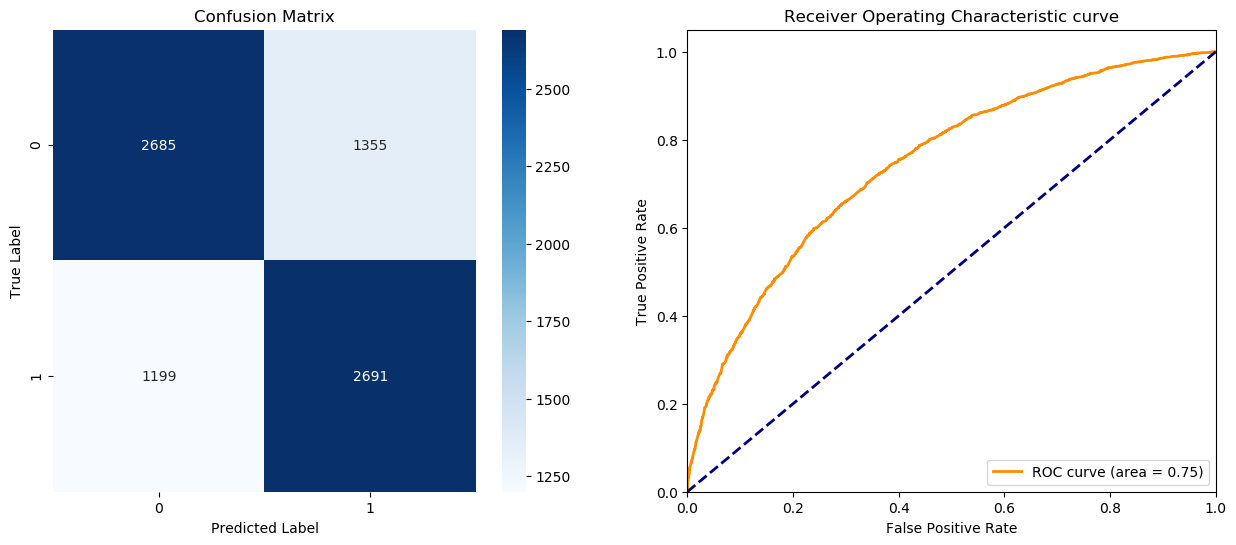

In [79]:
#adopted and modified from tutorial_medical_expenditure.ipynb
###########Test###########
lr_transf_metrics = test(dataset=orig_test,
                         model=LR_transf,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])

plot_model_performance(LR_transf, orig_test.features, orig_test.labels)
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])
###########Test###########

We see very similar results with the test dataset as well compared to the original results for the test dataset, suggesting that re-weighing significantly mitigated the bias of the classifier's predictions - although, in this case, we do see that for the test dataset, the 1-min(DI, 1/DI) value is now quite lower than 0.2, but it is close. The accuracy and similarly the F1 score on the test dataset is now decreased from approximately 70% to 68%, the balanced accuracy score remains relatively the same at 69%.

#### Random Forests

Now, we analyze the results for the random forest model on the reweighted dataset.

Accuracy: 0.6828653102404574
F1 score: 0.6808258588593671
Threshold corresponding to Best balanced accuracy: 0.5000
Best balanced accuracy: 0.6919
Corresponding 1-min(DI, 1/DI) value: 0.3239
Corresponding average odds difference value: -0.1023
Corresponding statistical parity difference value: -0.1788
Corresponding equal opportunity difference value: -0.1300
Corresponding Theil index value: 0.2063


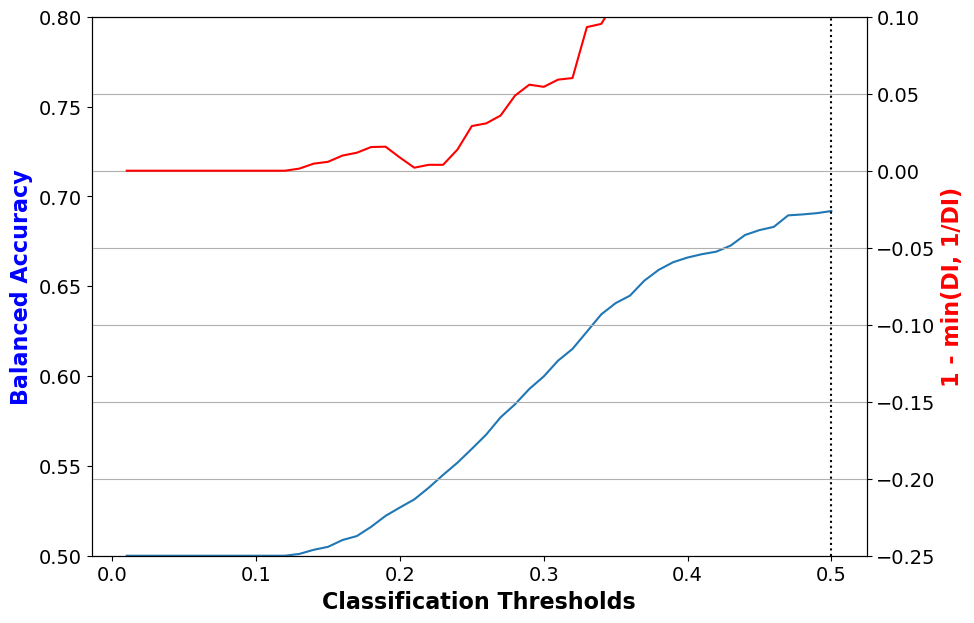

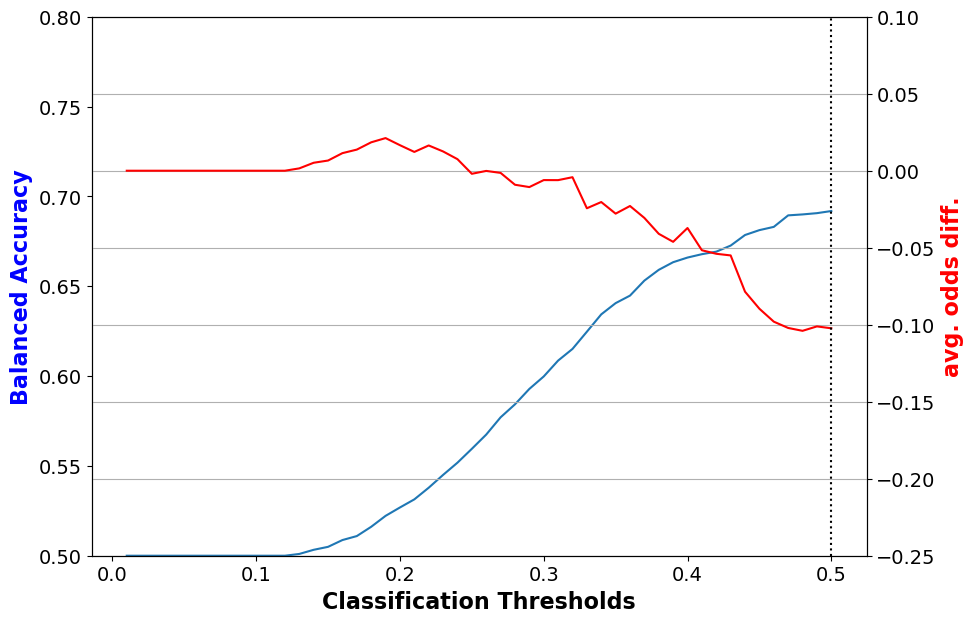

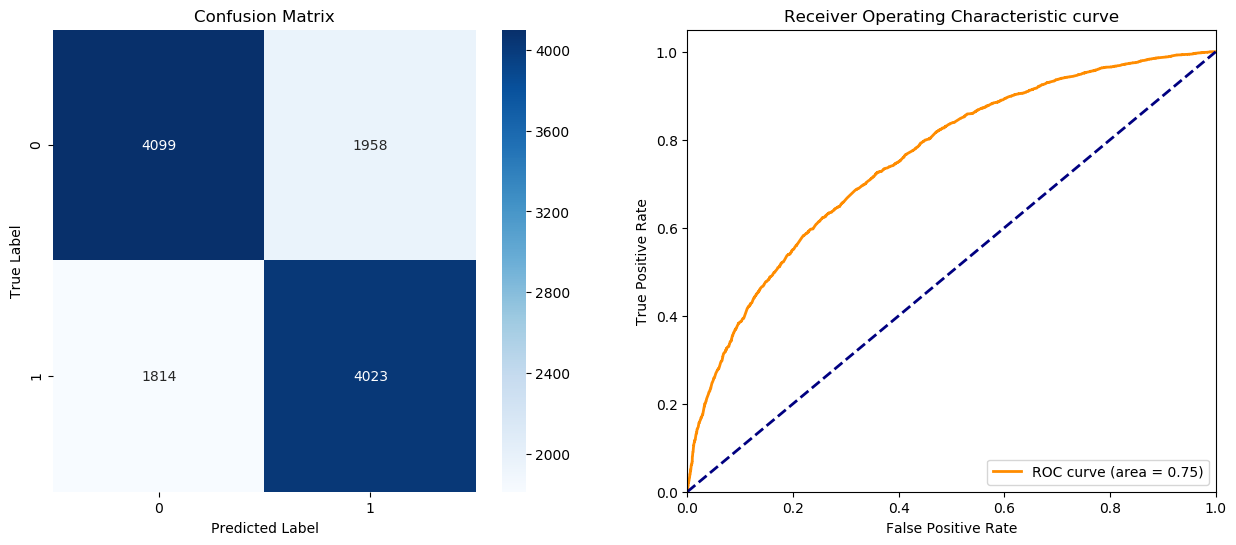

In [80]:
#adopted and modified from tutorial_medical_expenditure.ipynb

###########Training###########
dataset = dataset_transf_train
model = make_pipeline(RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
RF_transf = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)
###########Training###########

###########Validation###########

thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=orig_validate,
                   model=RF_transf,
                   thresh_arr=thresh_arr)
rf_transf_best_ind = np.argmax(val_metrics['bal_acc'])

disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

plot_model_performance(LR_transf, orig_validate.features, orig_validate.labels)
describe_metrics(val_metrics, thresh_arr)
###########Validation###########

<div class="alert alert-info">
<b>Metrics Explanation:</b> 

<br />

**Balanced accuracy** - Balanced accuracy is used to "avoid inflated performance estimates on imbalanced datasets... In the binary case, balanced accuracy is equal to the arithmetic mean of sensitivity (true positive rate) and specificity (true negative rate), or the area under the ROC curve with binary predictions rather than scores." - Taken from Scikit-Learn's documentation on model evaluation (https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score).

<br />

**Average odds difference** - This is the average of difference in false positive rates and true positive rates between unprivileged and privileged groups. A value of 0 implies both groups have equal beneﬁt, a value less than 0 implies higher beneﬁt for the privileged group and a value greater than 0 implies higher beneﬁt for the unprivileged group.

<br />

**Equal opportunity difference** - This is the difference in true positive rates between unprivileged and privileged groups. A value of 0 implies both groups have equal beneﬁt, a value less than 0 implies higher beneﬁt for the privileged group and a value greater than 0 implies higher beneﬁt for the unprivileged group.

<br />

**Statistical Parity Difference** - This is the difference in the probability of favorable outcomes between the unprivileged and privileged groups. A value of 0 implies both groups have equal beneﬁt, a value less than 0 implies higher beneﬁt for the privileged group, and a value greater than 0 implies higher beneﬁt for the unprivileged group.

<br />

**Disparate Impact** - This is the ratio in the probability of favorable outcomes between the unprivileged and privileged groups. A value of 1 implies both groups have equal beneﬁt, a value less than 1 implies higher beneﬁt for the privileged group, and a value greater than 1 implies higher beneﬁt for the unprivileged group.

<br />

**Theil index**: - "The Theil index is a statistic primarily used to measure economic inequality and other economic phenomena, though it has also been used to measure racial segregation. The Theil index TT is the same as redundancy in information theory which is the maximum possible entropy of the data minus the observed entropy." Taken from https://en.wikipedia.org/wiki/Theil_index

<br />

Citation: The below information is taken from the "AI Fairness 360: An Extensible Toolkit for Detecting, Understanding, and Mitigating Unwated Algorithmic Bias" (https://arxiv.org/pdf/1810.01943.pdf) paper and modified.


</div>



**Analyzing model metrics**: Now, we see the accuracy and F1-score of the algorithm has decreased to approximately 68%, and the balanced accuracy remains the same around approximately 69%.

**Analyzing fairness metrics**: Statistical parity difference, average odds difference, and the equal opportunity difference value have all significantly decreased, and are closer to 0 - not as much as the decrease in the values of these fairnes metrics exhibited for Logistic Regression, but the Random Forest model's predictions are relatively fairer. The Theil index has increased slightly, which contradicts the results demonstrated by the other metrics.

1-min(DI, 1/DI) is approximately equal to 0.3239, which is not less than 0.2, so improvement is still possible, but it is still significantly better compared to the value obtained for the original data of 0.8093.

It seems the re-weighing algorithm did not have as much of a great affect in terms of mitigating the bias for the random forest model compared to the logistic regression model.

**Clasification Threshold**: We see the best classification threshold seems to be 0.5.

Let's see what the algorithm's results are on the test dataset.

Accuracy: 0.6814627994955864
F1 score: 0.6817838246409673
Threshold corresponding to Best balanced accuracy: 0.5000
Best balanced accuracy: 0.6817
Corresponding 1-min(DI, 1/DI) value: 0.3652
Corresponding average odds difference value: -0.1225
Corresponding statistical parity difference value: -0.2058
Corresponding equal opportunity difference value: -0.1333
Corresponding Theil index value: 0.2103


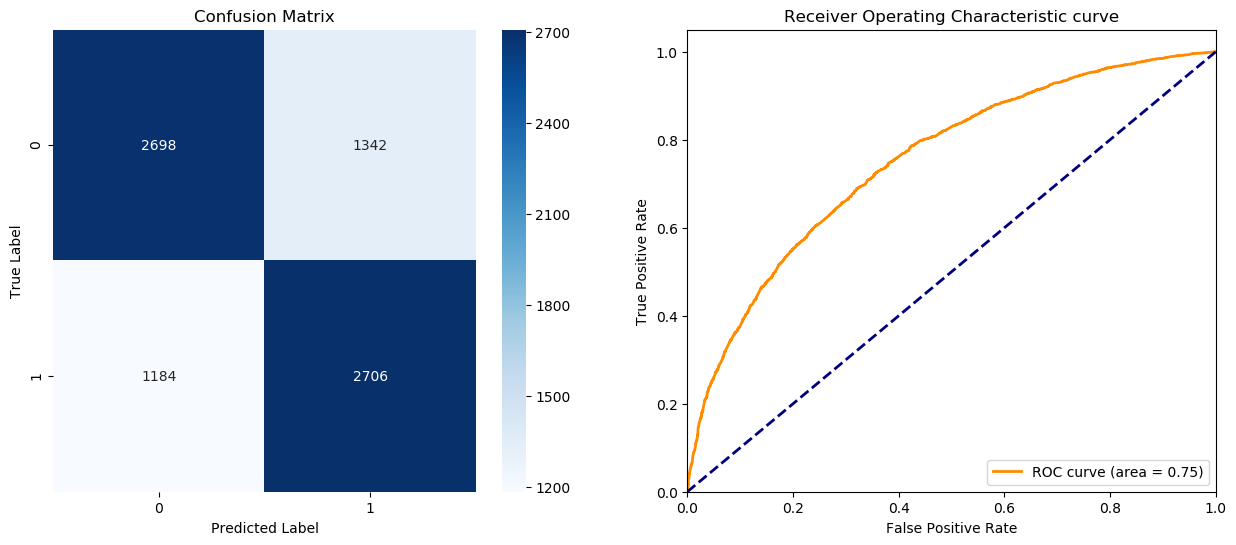

In [81]:
#adopted and modified from tutorial_medical_expenditure.ipynb

rf_transf_metrics = test(dataset=orig_test,
                         model=RF_transf,
                         thresh_arr=[thresh_arr[rf_transf_best_ind]])

plot_model_performance(RF_transf, orig_test.features, orig_test.labels)
describe_metrics(rf_transf_metrics, [thresh_arr[rf_transf_best_ind]])

We see good performance of the Random Forest model on the test dataset, and the value of the metrics has reduced compared to when running the Random Forest on the original test dataset. In particular, the average odds difference value seems to significantly decreased in addition to the statistical parity difference value. The accuracy, F1 score, and balanced accuracy do not seem to be impacted much; we actually see the balanced accuracy increase slightly.

#### Comparisons between the models

Now, let's inspect the feature importance plots for the two models on the training dataset.

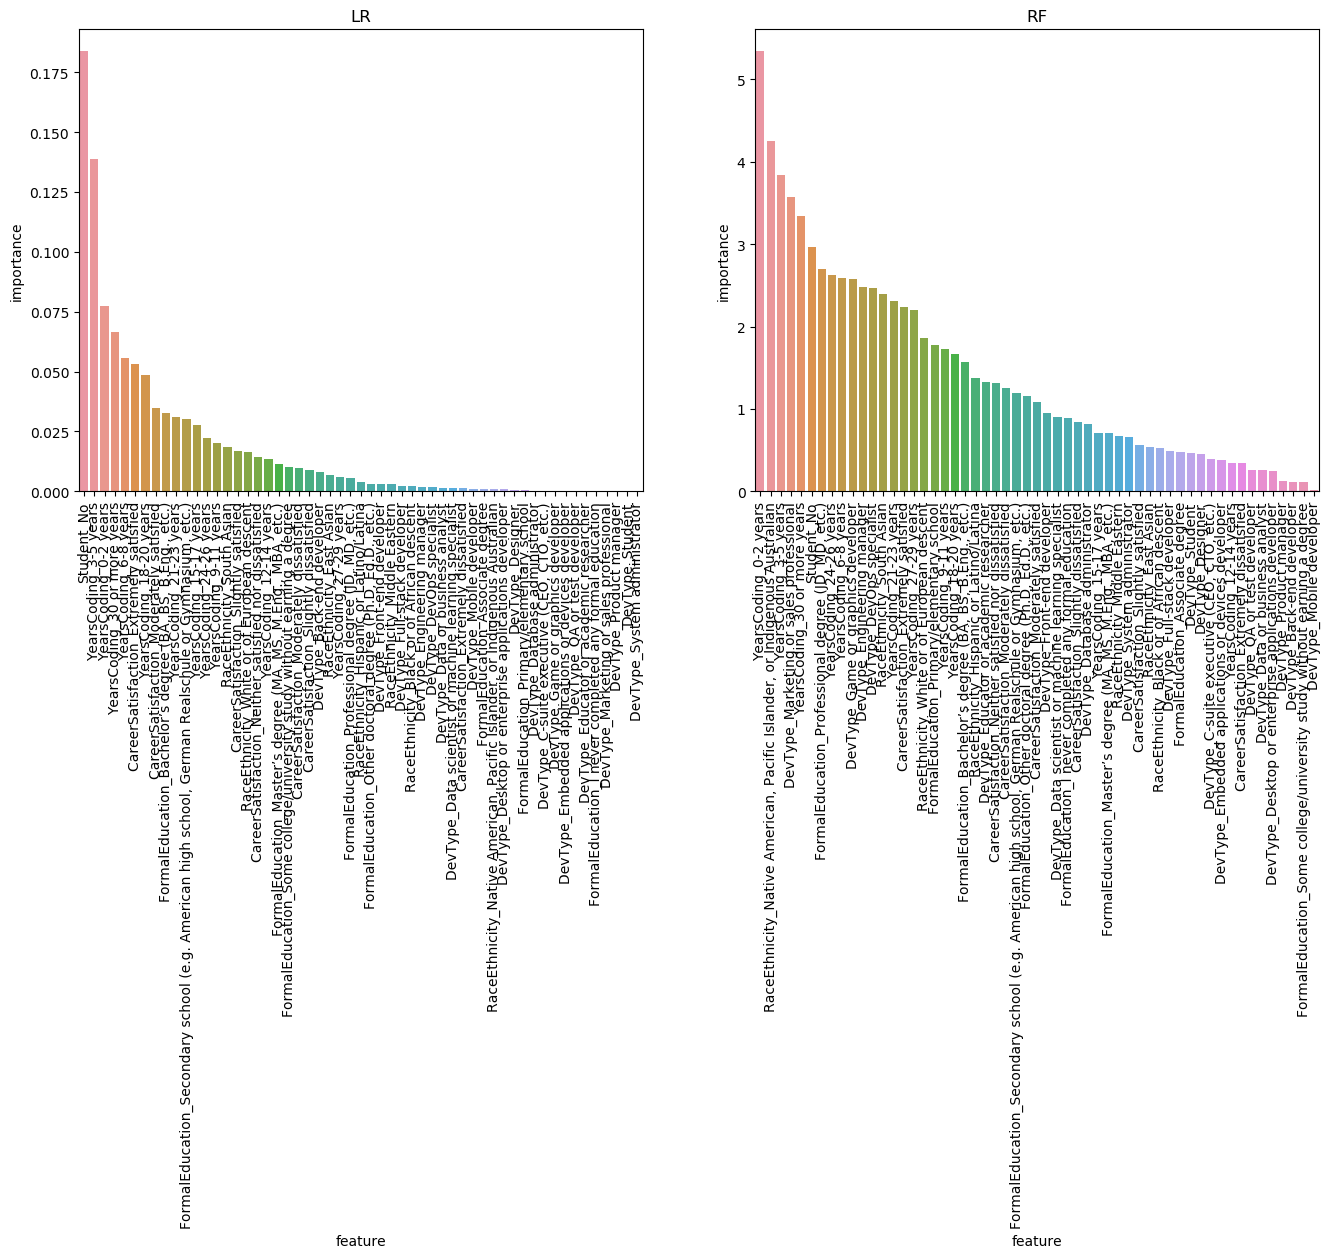

In [82]:
#credit: https://www.kaggle.com/garethjns/titanicsexism-fairness-in-ml#Fairness-metrics
    
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier],
                       names: List[str],
                       scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if 'LogisticRegression' in str(mod.named_steps):
        mod = mod.named_steps['logisticregression']
        imp = np.abs(mod.coef_.squeeze()) / scale 
        var = np.zeros(shape=imp.shape)
    elif 'RandomForest' in str(mod.named_steps):
        mod = mod.named_steps['randomforestclassifier']
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)
        
    return pd.DataFrame({'feature': names,
                         'importance': imp,
                         'std': var}).sort_values('importance',
                                                  ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)
        
fig, ax = plt.subplots(nrows=1, 
                       ncols=2,
                       figsize=(16, 6))

plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(LR_transf,
                                                names=dataset_transf_train.feature_names,  
                                                scale=dataset_transf_train.features.std()), ax=ax[1])
_ = ax[0].set_title('LR')


plot_feature_importance(x='feature', 
                        y='importance', 
                        data=feature_importance(RF_transf,
                                                names=dataset_transf_train.feature_names,  
                                                scale=dataset_transf_train.features.std()), ax=ax[0])
_ = ax[1].set_title('RF')


We see some interesting results - not being a student still has the highest variable importance for the logistic regression models, and the number of years of coding (0-2 years) still has the highest variable importance for the random forest model.

We see that for the LR model, being White or of European descent is no longer one of the first features in terms of variable importance. It is interesting to note that being White or of European descent has been ranked as higher in the variable importance plot for Random Forest compared to results on the original data - it is complicated to analyze why this is so from the given feature importance plots. 

Perhaps since the bias was not mitigated for Random Forest as well as it was for Logistic Regression, being White or of European descent could have more feature importance, although whether mitigating bias associated with a certain predictor is strongly related to feature importance or not is also an interesting question that I did not find a concrete answer for.

## Key-takeaways and future directions


**Key take-aways**: 

- Do White participants receive better benefits (i.e. salary higher than 60K) compared to non-White participants in the context of the Stack Overflow 2018 Developer Survey? The answer is "yes" according to the fairness metrics provided by the toolkit (such as statistical parity difference, average odds difference, and the equal opportunity difference value), the analyses we made in this report, and the implications of the pre-processing we performed (e.g. trimming the answers to the "check all that apply" questions). 

    This result has interesting implications from a public policy perspective, since some research also demonstates that Caucasian developers receive more salary compared to non-Caucasian developers (an article by Quartz on the topic: https://qz.com/906138/programming-while-black-will-cost-you-10000-in-salary/), whereas other research contends this. Defining practical recommendations based on the results on the Stack Overflow 2018 Developer Survey on salary benefits based on race is challenging, as different problem formalizations for this particular dataset and others still need to be explored, in addition to the strengths and weaknesses of the fairness metrics covered.
    
    
- It seems the reweighing algorithm did not have as much of a great effect in terms of mitigating the bias for the random forest model compared to the logistic regression model, but the results demonstrate that reweighing is an efficient way of mitigating bias for this dataset. 


- The AIF360 toolkit is effective at mitigating bias in this dataset, regardless of the label imbalance in this dataset.


- Compared to the other metrics, the Theil index did not seem to demonstrate a reduction in bias even after reweighing, whereas metrics like 1-min(DI, 1/DI) and statistical parity difference did, suggesting that either this metric might not be suited for explaining the bias of the classifiers' predictions for this use case or the other metrics are missing some details the Theil Index is including (e.g. perhaps there is still redundancy in the dataset, as the Theil index is a measure of redundancy).

Future directions include:

- Tuning the hyperparameters of the machine learning model to find the optimal model for the validation set.

- Trying different pre-processing algorithms.

- Trying different protected attributes, like gender, and other problem formalizations (trying to mitigate bias with being/not being Native American as a protected attribute, using different features such as job search status, etc).

## Credits

Some of the code blocks in this document are borrowed and modified from the tutorials in the AIF360 examples repository (https://github.com/IBM/AIF360/tree/master/examples), such as for training and validating machine learning models, in addition to Gareth Jones' Jupyter Notebook (https://github.com/garethjns/Kaggle-Titanic/blob/master/titanicsexism-fairness-in-ml.ipynb) and Nathan Lauga's Kaggle Kernel (https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml), which are two of the few resources I found that are working tutorials using the toolkit outside of the AIF360 examples repository. These tutorials use a different dataset instead of what is already provided by the toolkit and provides code for feature importance plots and visualizing the outputs of the logistic regression and random forest models, which I reuse and modify below.

All code blocks taken from other sources are properly cited via the comments/in the supplementing text in this notebook.

Additional References:

- Bellamy, R.K., Dey, K., Hind, M., Hoffman, S.C., Houde, S., Kannan, K., Lohia, P., Martino, J., Mehta, S., Mojsilovic, A., Nagar, S., Ramamurthy, K.N., Richards, J.T., Saha, D., Sattigeri, P., Singh, M., Varshney, K.R., & Zhang, Y. (2018). AI Fairness 360: An Extensible Toolkit for Detecting, Understanding, and Mitigating Unwanted Algorithmic Bias. ArXiv, abs/1810.01943.
- Kamiran, F., & Calders, T. (2011). Data preprocessing techniques for classification without discrimination. Knowledge and Information Systems, 33(1), 1-33. doi:10.1007/s10115-011-0463-8
- Information taken from other sources in order to help define fairness metrics, such as Wikipedia and the scikitlearn documentation, are documented in the supplementary text with links.

# Thank you!